# Weather Forecasting with Time-Series Analysis

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


## Dataset

This tutorial uses a [weather time series dataset](https://www.bgc-jena.mpg.de/wetter/) recorded by the [Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/).

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016, and only four columns (Pressure, Relative Humidity, Temperature, and Wind Speed) will be retained. This section of the dataset was prepared by François Chollet for his book Deep Learning with Python.

In [2]:
import os

os.getcwd()

'/Users/farhan/Desktop/edge/time_series_model/Forecast_Model'

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    cache_dir='../data',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)


13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:
csv_path

'/tmp/.keras/datasets/jena_climate_2009_2016_extracted'

As the dataset records every 10 minutes (6 records every hour), we only take the last 10 minutes as hourly data.

In [5]:
df = pd.read_csv(csv_path + '/jena_climate_2009_2016.csv')
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [6]:
columns_to_keep = ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']

In [7]:
df = df[columns_to_keep]

In [8]:
df.head()

,p (mbar),T (degC),rh (%),wv (m/s)
5,996.50,-8.05,94.4,0.21
11,996.62,-8.88,93.2,0.25
17,996.84,-8.81,93.5,0.18
23,996.99,-9.05,92.6,0.10
29,997.46,-9.63,92.2,0.40


## Visualising Our Data

Here is the evolution of a few features over time

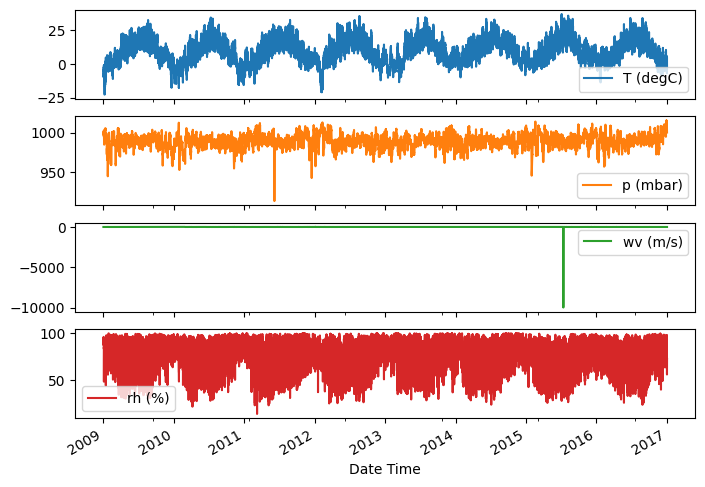

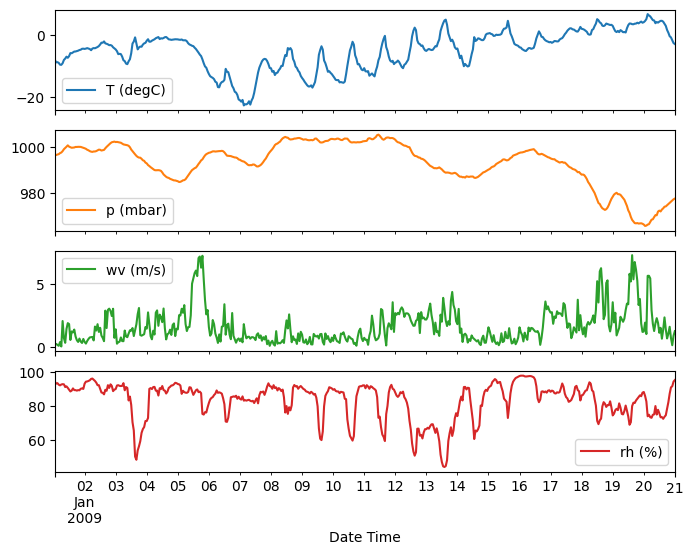

In [9]:
plot_cols = ['T (degC)', 'p (mbar)', 'wv (m/s)', 'rh (%)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)


You can see that there is an erroneous Wind Velocity (wv) with a value of -9999. We shall change it to 0.0 m/s.

In [10]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

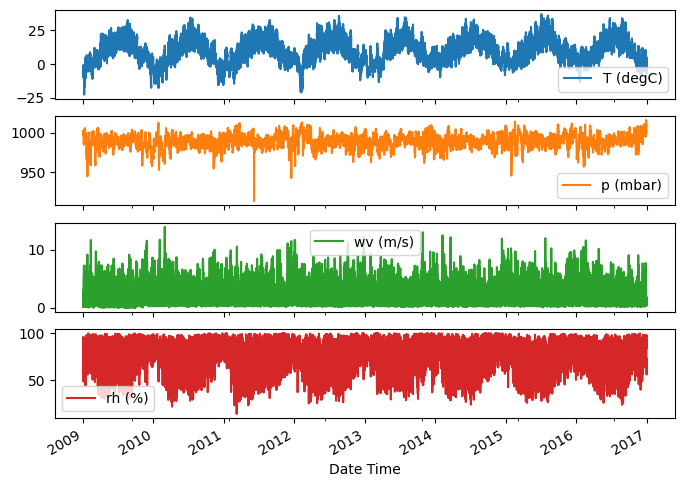

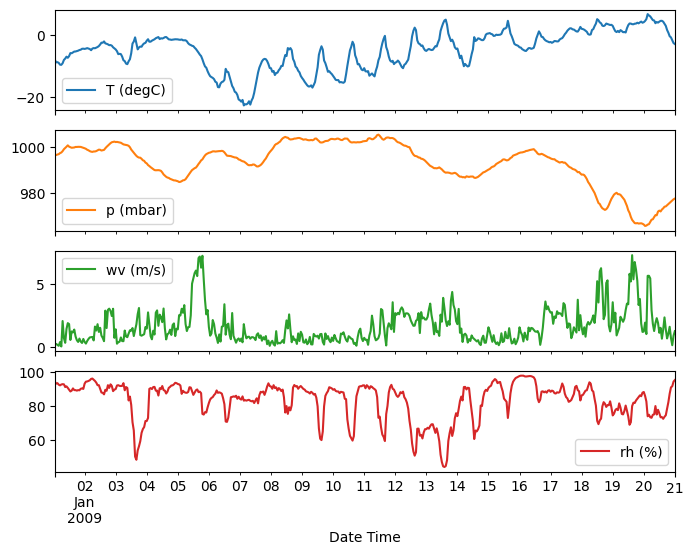

In [11]:
plot_cols = ['T (degC)', 'p (mbar)', 'wv (m/s)', 'rh (%)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)


In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.72,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.48,37.28
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.40,100.00
wv (m/s),70091.0,2.130539,1.543098,0.00,0.99,1.76,2.86,14.01


## Split the dataset into train, validation, and test splits

- Train dataset: 70%
- Validation dataset: 20%
- Test dataset: 10%

In [13]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


## Normalize the Data

In [14]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_86514/2828228499.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


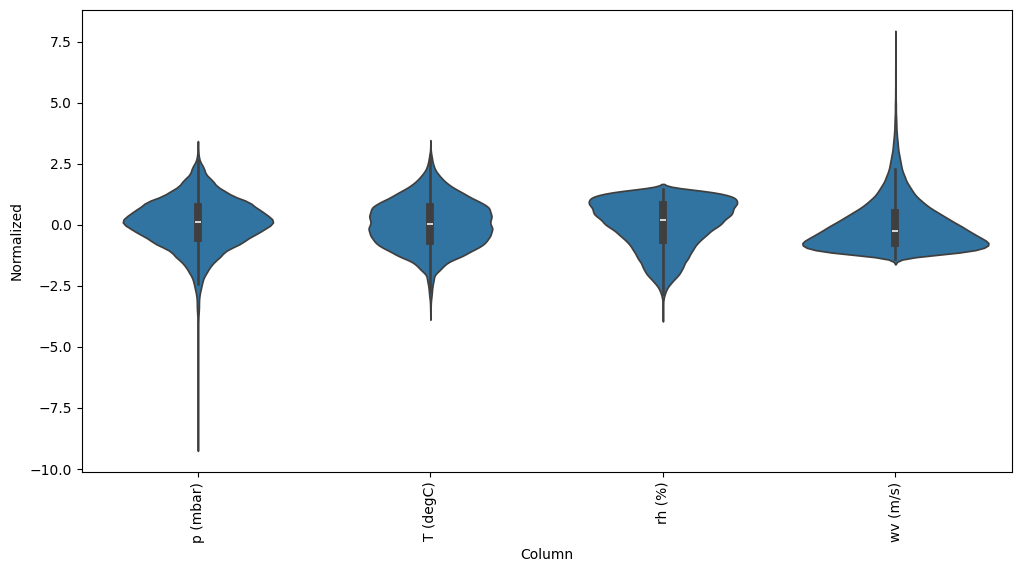

In [15]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)


### Data Windowing

We will make use of a strategy that is known as data windowing, which can be used for any model (i.e., RNN, CNN, etc.). Here is an example of how it works:

1. Using readings from 14 days prior to record the temperature in the next two days -> Input width: 14, Offset width: 2

To do this, we can start off with defining a `WindowGenerator` class.

In [16]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.example_type = "train"

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Create a window with:

- `input_width` = 6 (6 hours of data)
- `label_wdith` = 6 (next 6 hours)
- `shift` = 1

In [17]:
w1 = WindowGenerator(input_width=6, label_width=6, shift=1,
                     label_columns=['T (degC)'])
w1


Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [1 2 3 4 5 6]
Label column name(s): ['T (degC)']

In [18]:
import tensorflow as tf

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [19]:
# Stack three slices, the length of the total window.
window_1 = tf.stack([np.array(train_df[:w1.total_window_size]), # First time batch (0-15)
                           np.array(train_df[100:100+w1.total_window_size]), # Second time batch (100-115)
                           np.array(train_df[200:200+w1.total_window_size])]) # Third time batch (200-215)

window_1_inputs, window_1_labels = w1.split_window(window_1)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {window_1.shape}')
print(f'Inputs shape: {window_1_inputs.shape}')
print(f'Labels shape: {window_1_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 7, 4)
Inputs shape: (3, 6, 4)
Labels shape: (3, 6, 1)


Plot the window

In [20]:
w1.example = window_1_inputs, window_1_labels

In [21]:
import matplotlib.pyplot as plt

def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example  # Get example batch
    plot_col_index = self.column_indices[plot_col]  # Get column index
    max_n = min(max_subplots, len(inputs))  # Limit number of subplots
    
    # Get mean and std for unnormalization
    mean_value = train_mean[plot_col]
    std_value = train_std[plot_col]

    ### **Plot Normalized Values**
    plt.figure(figsize=(12, 8))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [Normalized]')
        
        # Plot Normalized Inputs
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs (Normalized)', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        # Plot Normalized Labels
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels (Normalized)', c='#2ca02c', s=64)

        if model is not None:
            predictions = model(inputs)  # Get model predictions
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions (Normalized)',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')
    plt.title(f'Normalized {plot_col} Predictions')
    plt.show()

    ### **Plot Unnormalized Values**
    plt.figure(figsize=(12, 8))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [Original Scale]')

        # Unnormalize inputs (not needed, since we only plotted labels and predictions before)
        
        # Unnormalize labels
        labels_unnorm = (labels[n, :, label_col_index] * std_value) + mean_value
        plt.scatter(self.label_indices, labels_unnorm,
                    edgecolors='k', label='Labels (Unnormalized)', c='blue', marker='o', s=64)

        if model is not None:
            # Unnormalize predictions
            predictions_unnorm = (predictions[n, :, label_col_index] * std_value) + mean_value
            plt.scatter(self.label_indices, predictions_unnorm,
                        marker='X', edgecolors='k', label='Predictions (Unnormalized)',
                        c='red', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')
    plt.title(f'Unnormalized {plot_col} Predictions')
    plt.show()

# Assign the modified plot function to the WindowGenerator class
WindowGenerator.plot = plot

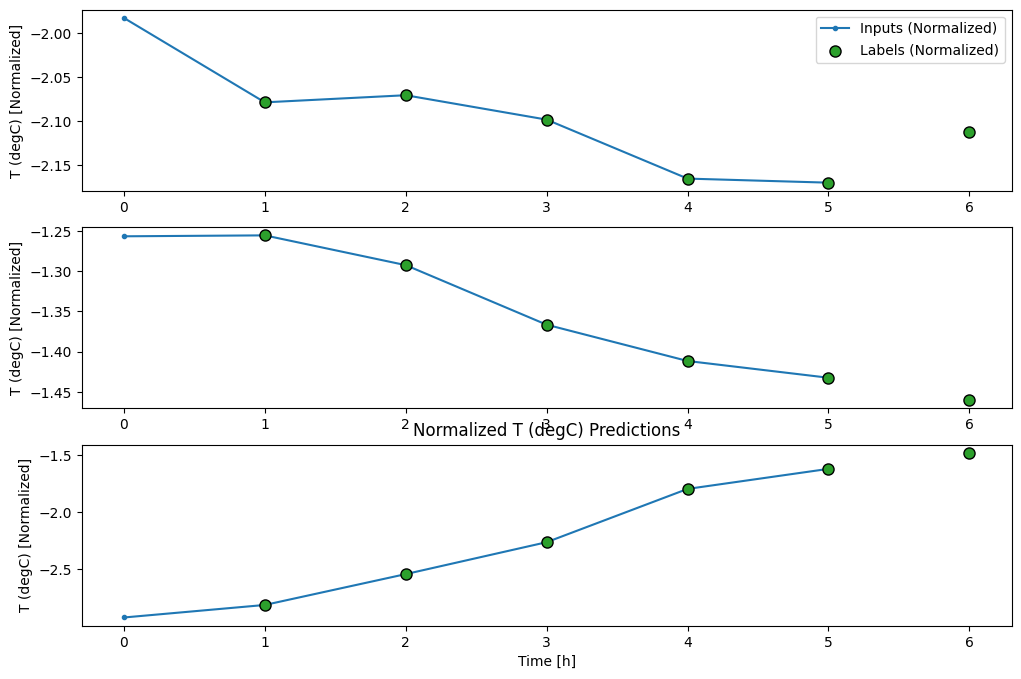

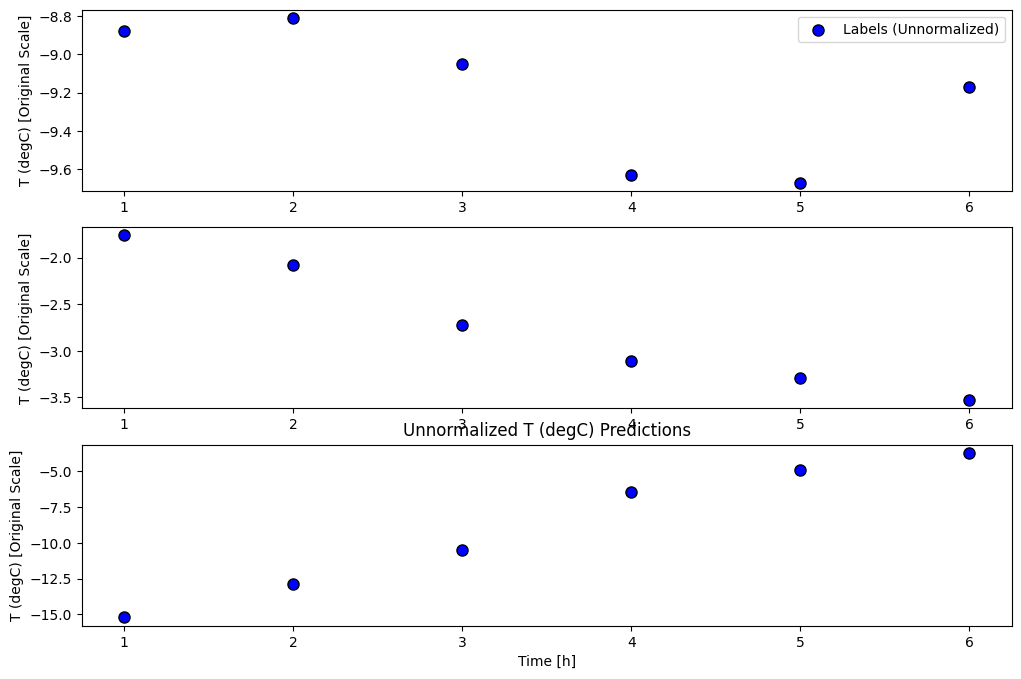

In [22]:
w1.plot()

## Convert the dataset into a time series DataFrame

In [23]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [24]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    if self.example_type == "train":
        result = next(iter(self.train))
    elif self.example_type == "val":
        result = next(iter(self.val))
    else:
        result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

def set_example_type(self, example_type="train"):
    self.example_type = example_type

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.set_example_type = set_example_type

In [25]:
# Each element is an (inputs, label) pair.
w1.train.element_spec

(TensorSpec(shape=(None, 6, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None))

In [26]:
for example_inputs, example_labels in w1.train.take(1): # Takes one batch, with 32 samples per batch
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 6, 4)
Labels shape (batch, time, features): (32, 6, 1)


2025-03-18 15:57:05.666397: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


With this, we take a batch, containing 32 samples. A sample will include a window containing an (1) input window with 14 time steps with each having 4 sensor readings; (2) label window with 2 time steps with each having 1 sensor (temperature) reading.

## Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature one hour into the future, given the current value of all features. The current values include the current temperature.

So, start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

In [27]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [28]:
single_step_window.train.element_spec

(TensorSpec(shape=(None, 1, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [29]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

### Baseline Model (Temperature)

In [30]:
baseline = Baseline(label_index=column_indices['T (degC)'])

In [31]:
baseline.label_index

1

In [32]:
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 0.0134 - mean_absolute_error: 0.0801


Wide window, input = 24 (24 hours), label_width = 24 (24 hours)

In [33]:
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1,
                     label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [34]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 4)
Output shape: (32, 24, 1)


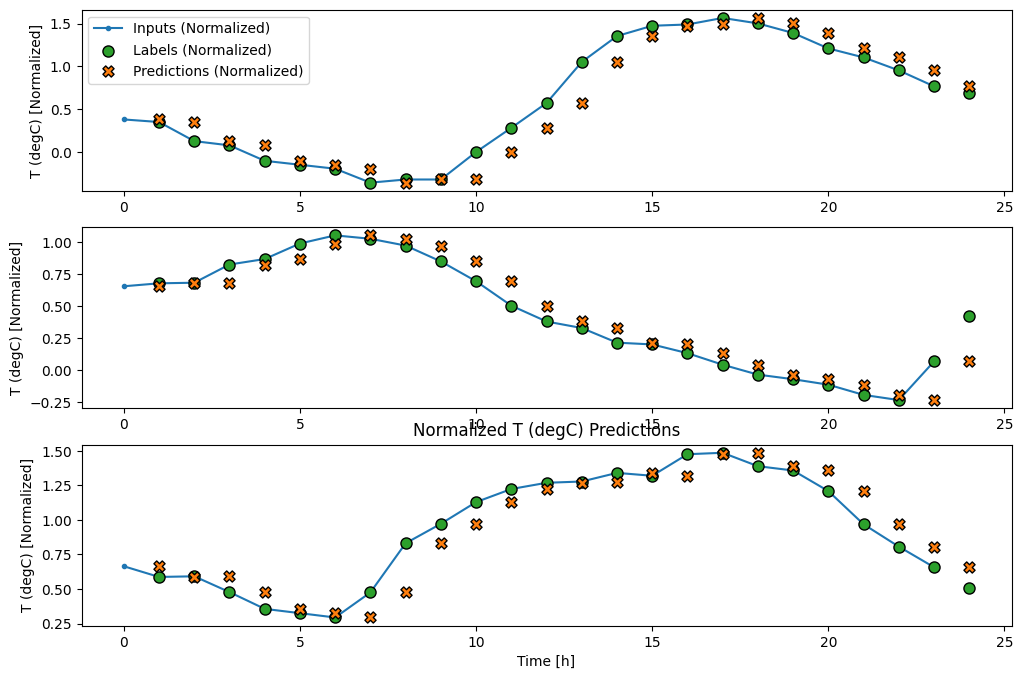

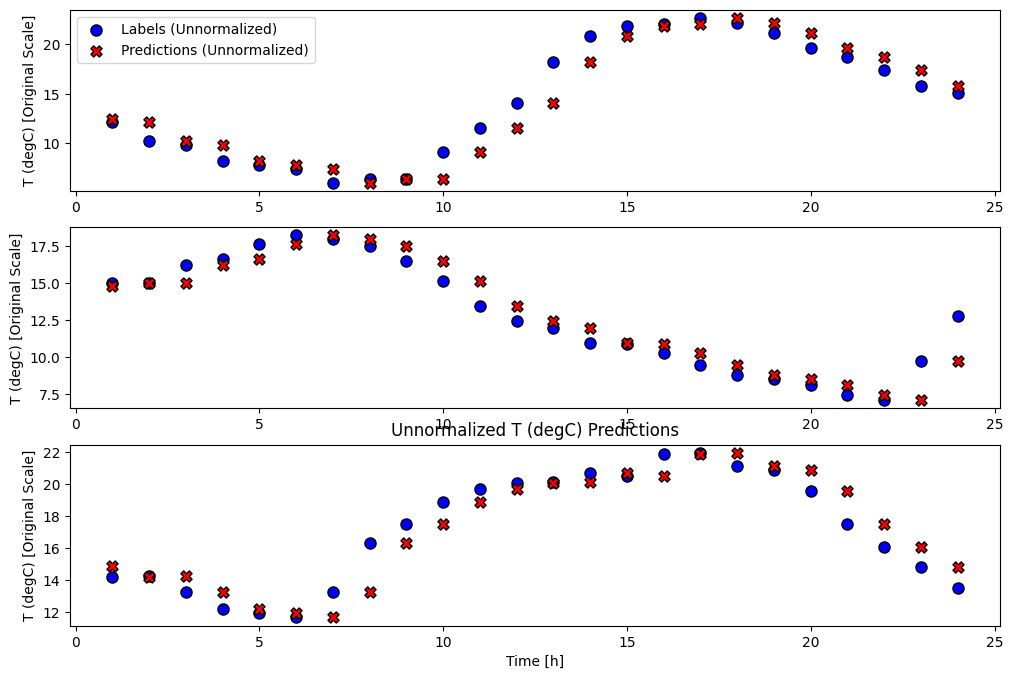

In [35]:
wide_window.plot(baseline)

### Baseline Model (Pressure)

In [36]:
baseline_pressure = Baseline(label_index=column_indices['p (mbar)'])

In [37]:
single_step_window_pressure = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['p (mbar)'])

single_step_window_pressure

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['p (mbar)']

In [38]:
baseline_pressure.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline_pressure.evaluate(single_step_window_pressure.val, return_dict=True)
performance['Baseline'] = baseline_pressure.evaluate(single_step_window_pressure.test, verbose=0, return_dict=True)

439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 0.0032 - mean_absolute_error: 0.0416


Wide window

In [39]:
wide_window_pressure = WindowGenerator(input_width=24, label_width=24, shift=1,
                     label_columns=['p (mbar)'])

wide_window_pressure

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['p (mbar)']

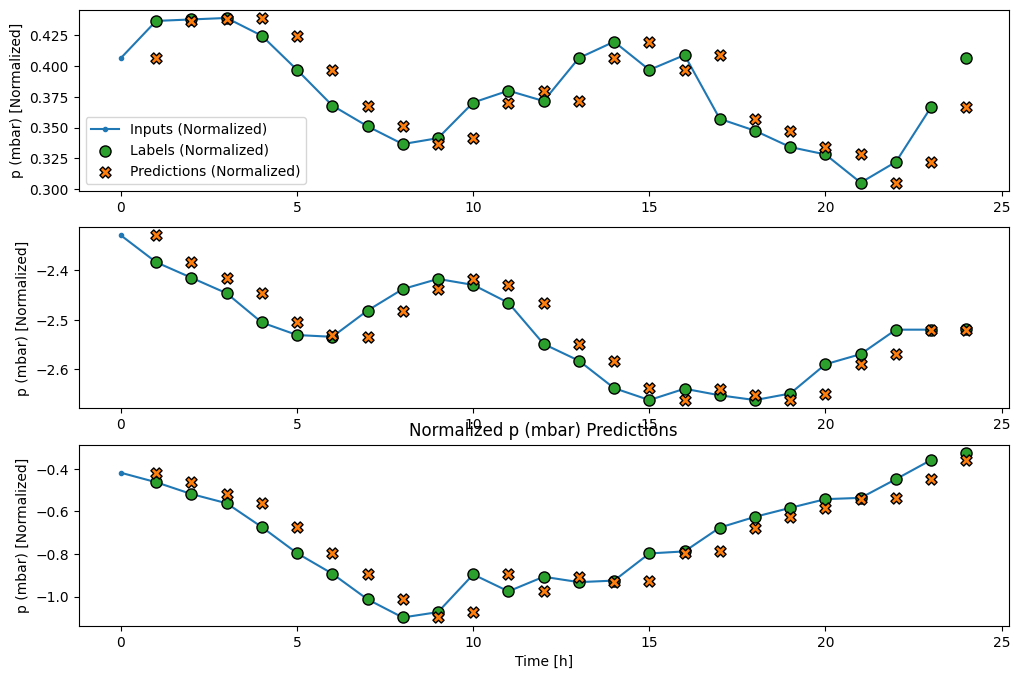

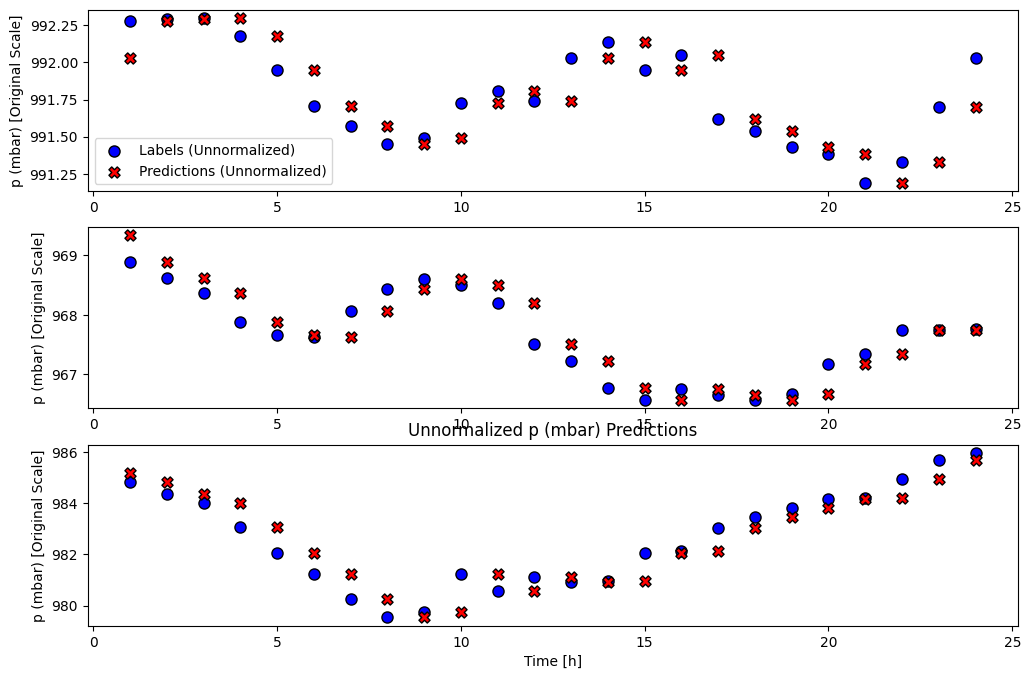

In [40]:
wide_window_pressure.plot(baseline_pressure, plot_col='p (mbar)')

### Baseline Model (Relative Humidity)

In [41]:
baseline_rh = Baseline(label_index=column_indices['rh (%)'])

In [42]:
single_step_window_rh = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['rh (%)'])

single_step_window_rh

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['rh (%)']

In [43]:
baseline_rh.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline_rh.evaluate(single_step_window_rh.val, return_dict=True)
performance['Baseline'] = baseline_rh.evaluate(single_step_window_rh.test, verbose=0, return_dict=True)

439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.0715 - mean_absolute_error: 0.1760


In [44]:
wide_window_rh = WindowGenerator(input_width=24, label_width=24, shift=1,
                     label_columns=['rh (%)'])

wide_window_rh

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['rh (%)']

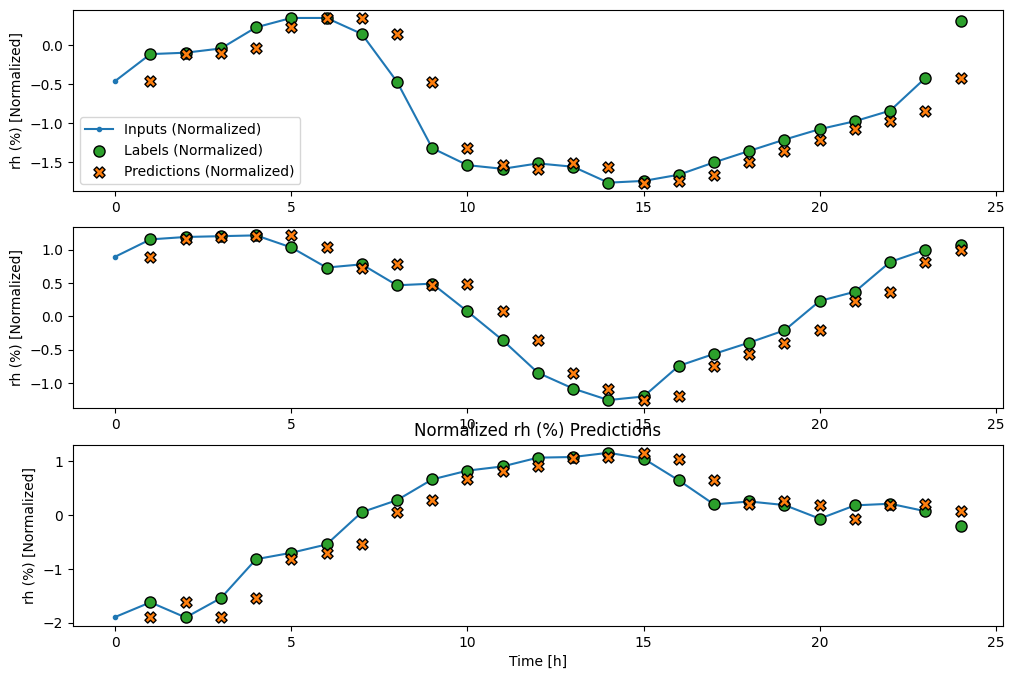

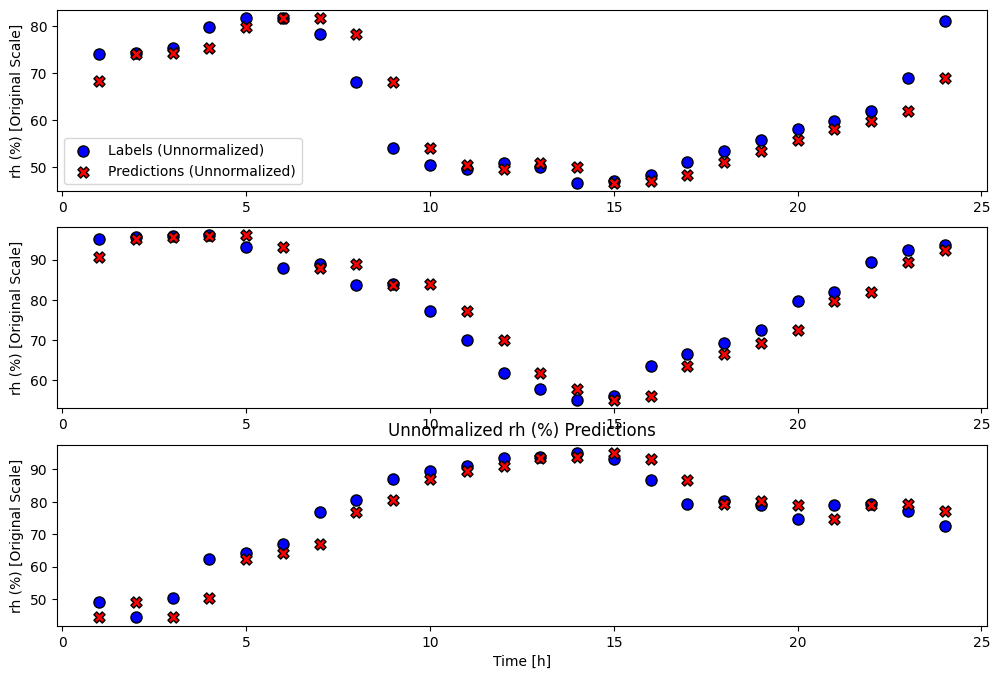

In [45]:
wide_window_rh.plot(baseline_rh, plot_col='rh (%)')

### Baseline Model (Wind Speed)

In [46]:
baseline_wv = Baseline(label_index=column_indices['wv (m/s)'])

In [47]:
single_step_window_wv = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['wv (m/s)'])

single_step_window_wv

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['wv (m/s)']

In [48]:
baseline_wv.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline_wv.evaluate(single_step_window_wv.val, return_dict=True)
performance['Baseline'] = baseline_wv.evaluate(single_step_window_wv.test, verbose=0, return_dict=True)

439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 0.4187 - mean_absolute_error: 0.4606


In [49]:
wide_window_wv = WindowGenerator(input_width=24, label_width=24, shift=1,
                     label_columns=['wv (m/s)'])

wide_window_wv

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['wv (m/s)']

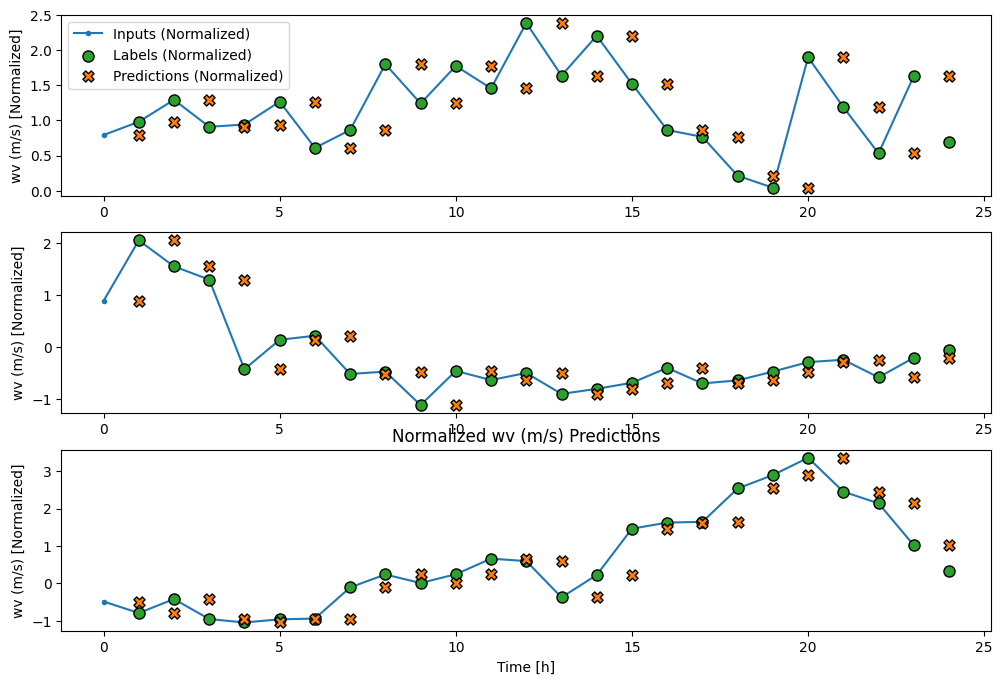

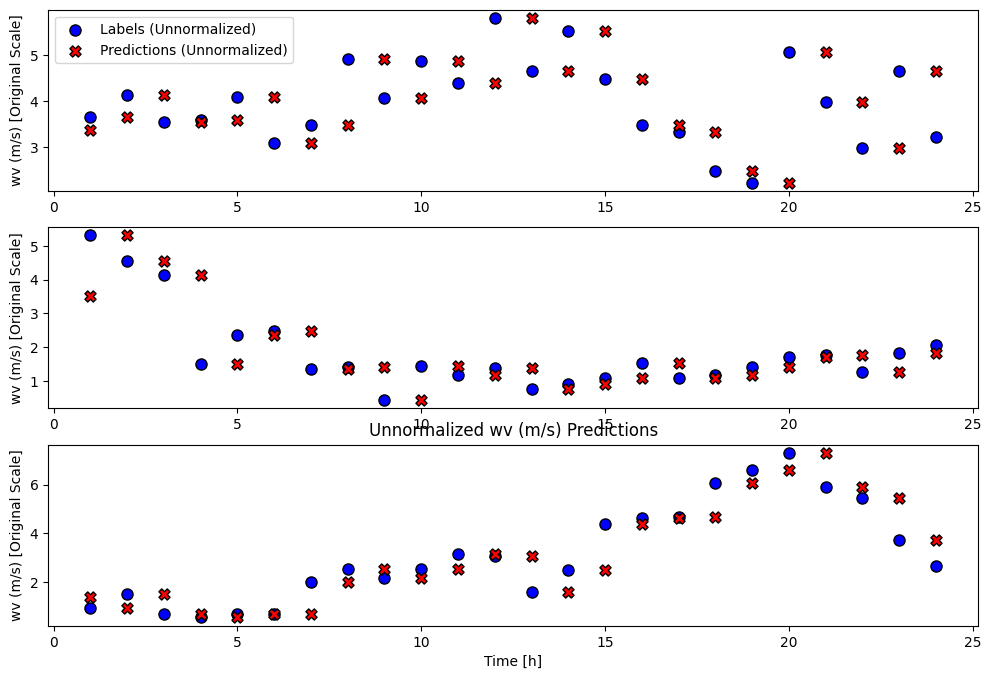

In [50]:
wide_window_wv.plot(baseline_wv, plot_col='wv (m/s)')

## Multi-Step Dense

The Baseline Model in multi-step forecasting does not learn patterns—it simply copies the last observed value for all future predictions.

For a 24-hour input & 24-hour output window, the baseline model just repeats the last known 24-hour sequence as its prediction. Evaluation then compares this naive forecast against actual future values to measure how much a trained model improves beyond just “guessing past values".

Now, we will explore a **Multi-Step Dense** model, which allows the model to actually learn patterns from the previous input features from multiple prior time steps.


Define `compile_and_fit` function

In [51]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=5, optimizer='adam', learning_rate=1e-3, epochs=50, verbose=1):
   early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      patience=patience,
      restore_best_weights=True,
      mode='min'
   )

   # Choose optimizer
   if optimizer.lower() == 'adam':
      opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
   elif optimizer.lower() == 'rmsprop':
      opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
   else:
      raise ValueError("Optimizer not supported. Use 'adam' or 'rmsprop'.")

   # Compile model
   model.compile(
      loss=tf.keras.losses.MeanSquaredError(),
      optimizer=opt,
      metrics=[tf.keras.metrics.MeanAbsoluteError()]
   )

   # Train model
   history = model.fit(
      window.train,
      epochs=epochs,
      validation_data=window.val,
      callbacks=[early_stopping],
      verbose=verbose
   )

   return history

Input time window of 3 steps, output temperature label (true label) in the next hour

In [52]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

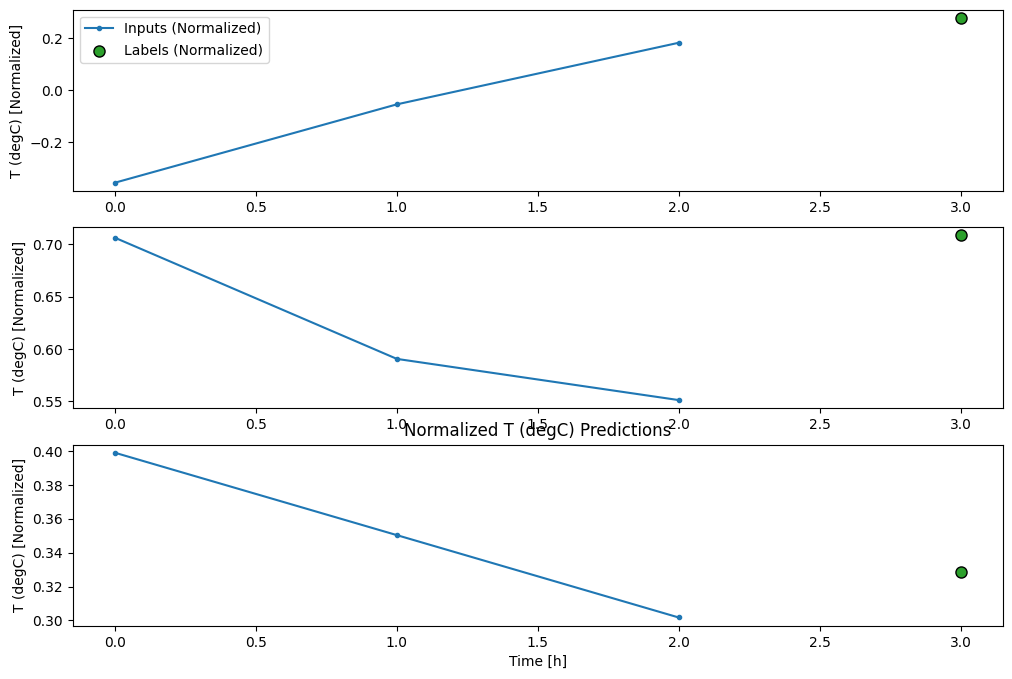

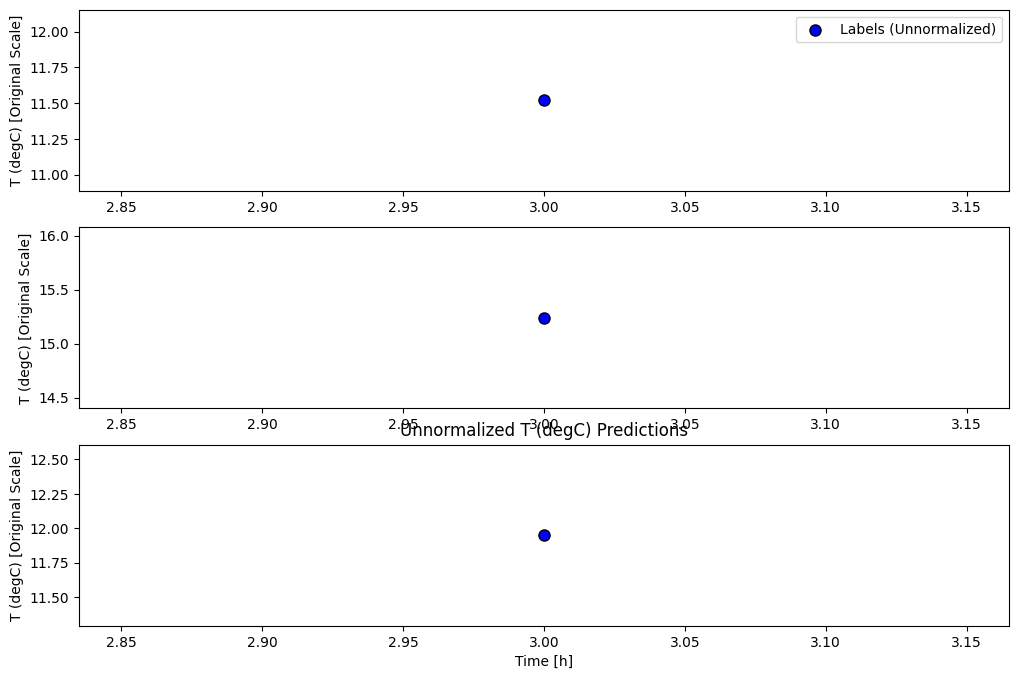

Text(0.5, 0.98, 'Given 3 hours of inputs, predict 1 hour into the future.')

<Figure size 800x600 with 0 Axes>

In [53]:
conv_window.plot()
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")

Define Multi-Dense Step Model

In [54]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [55]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 4)
Output shape: (32, 1, 1)


In [56]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 0.0076 - mean_absolute_error: 0.0610


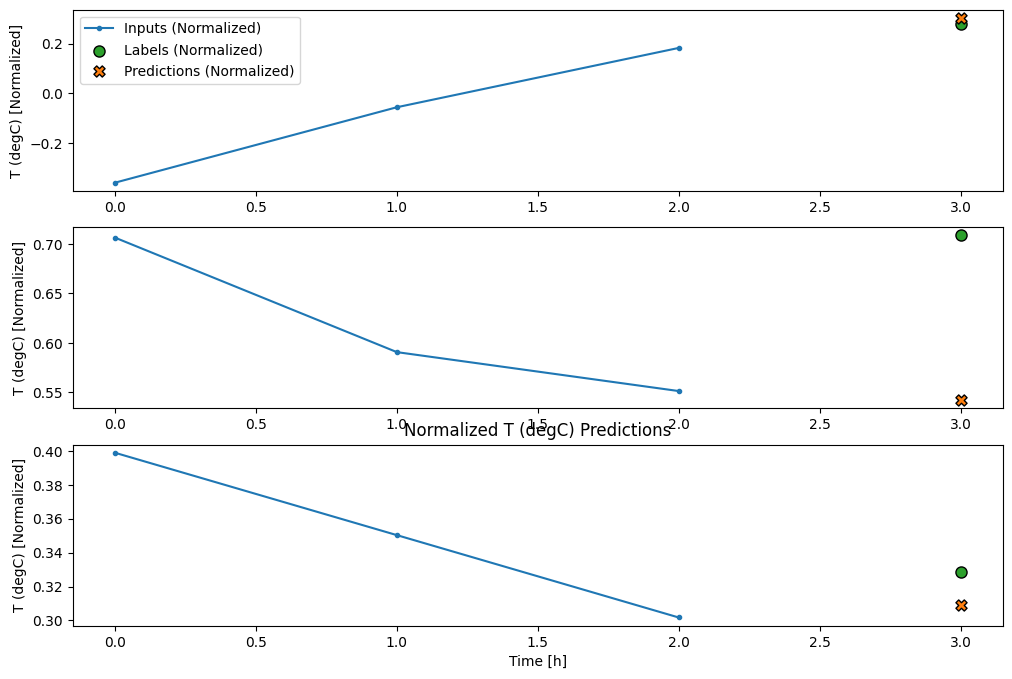

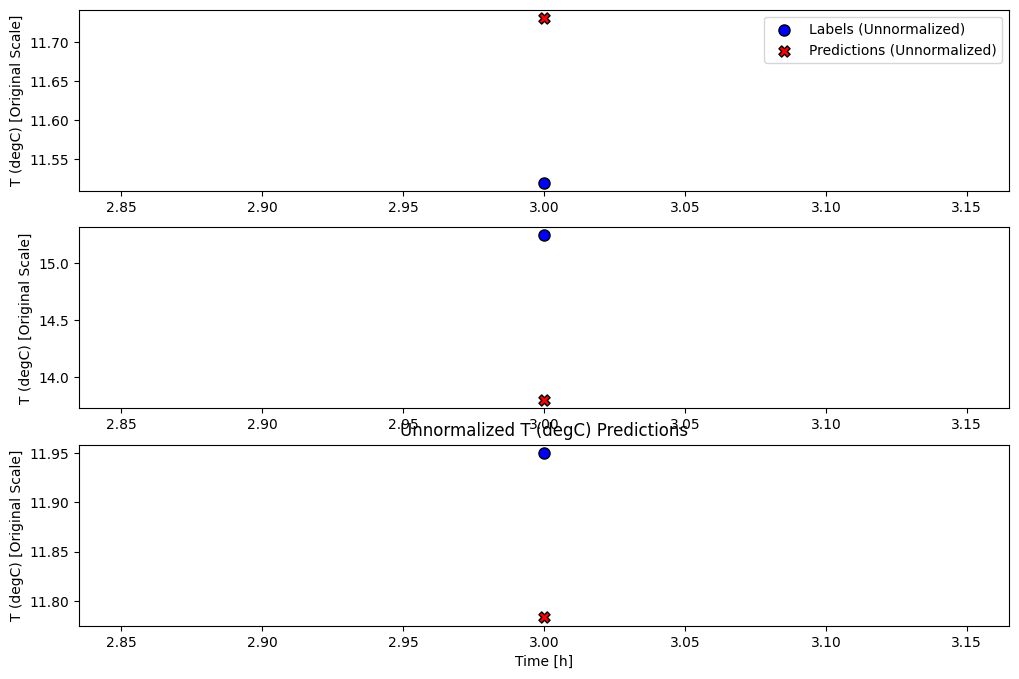

In [57]:
conv_window.plot(multi_step_dense)

In [58]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')


Input shape: (32, 24, 4)

ValueError:Exception encountered when calling Sequential.call().

Input 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 12, but received input with shape (32, 96)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 24, 4), dtype=float32)
  • training=None
  • mask=None


The error message above tells us that the model does not accept any inputs that are of different shape to (32, 3, 14), with 3 being the input window size. To allow flexibility with the window size inputs, we should use **Convolutional Neural Network** instead.

## Convolutional Neural Network

In [59]:
CONV_WIDTH = 3

In [60]:
conv_model_temp = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [61]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model_temp(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 4)
Output shape: (32, 1, 1)


Train the model

In [62]:
history = compile_and_fit(conv_model_temp, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model_temp.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model_temp.evaluate(conv_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - loss: 0.0077 - mean_absolute_error: 0.0584


In [63]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model_temp(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 4)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Reason for why the output window is shorter than the labels (22 vs 24):

- Convolution Operation Causes Reduction in Output Size
    - A 1D CNN slides a kernel (filter) across the time dimension, applying transformations at each step. So:
        - Kernel Size = 3 (Each output time step -> Mapped to 3 input time steps)
        - Some time steps get lost during convolution
        - Results in fewer time steps in the output

- If input width is 24 and CNN kernel size = 3:
    - First output timestep *mapped to* 3 input timestep
    - Last 2 timesteps gets dropped because filter cannot slide beyond the input
    - Output shrinks to 22 from 24

- To mitigate this, we add some extra input time steps so we can get exactly 24 output time steps.


### Temperature

#### Test Set, 3 Samples (Temperature)

In [64]:
CONV_WIDTH = 4
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
train_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

In [65]:
conv_model_temp = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [66]:
history = compile_and_fit(conv_model_temp, train_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model_temp.evaluate(train_window.val, return_dict=True)
performance['Conv'] = conv_model_temp.evaluate(train_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 0.0071 - mean_absolute_error: 0.0572


In [67]:
# Create demo window
demo_window = WindowGenerator(
    input_width=INPUT_WIDTH, 
    label_width=LABEL_WIDTH, 
    shift=1, 
    label_columns=['T (degC)']
)

demo_window.set_example_type("test") # Set example type to test

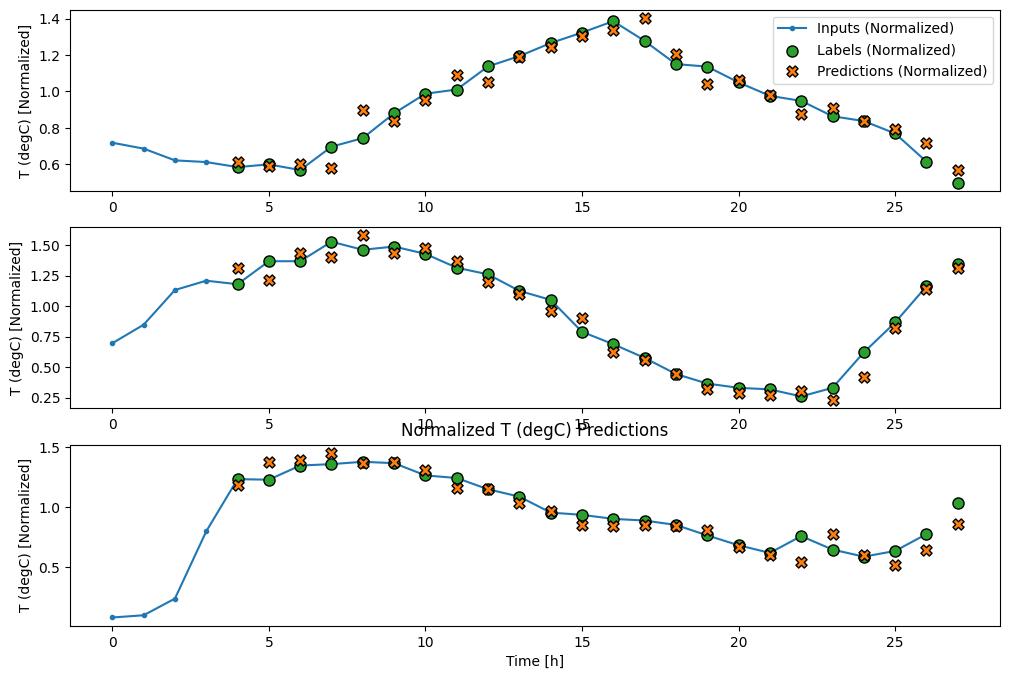

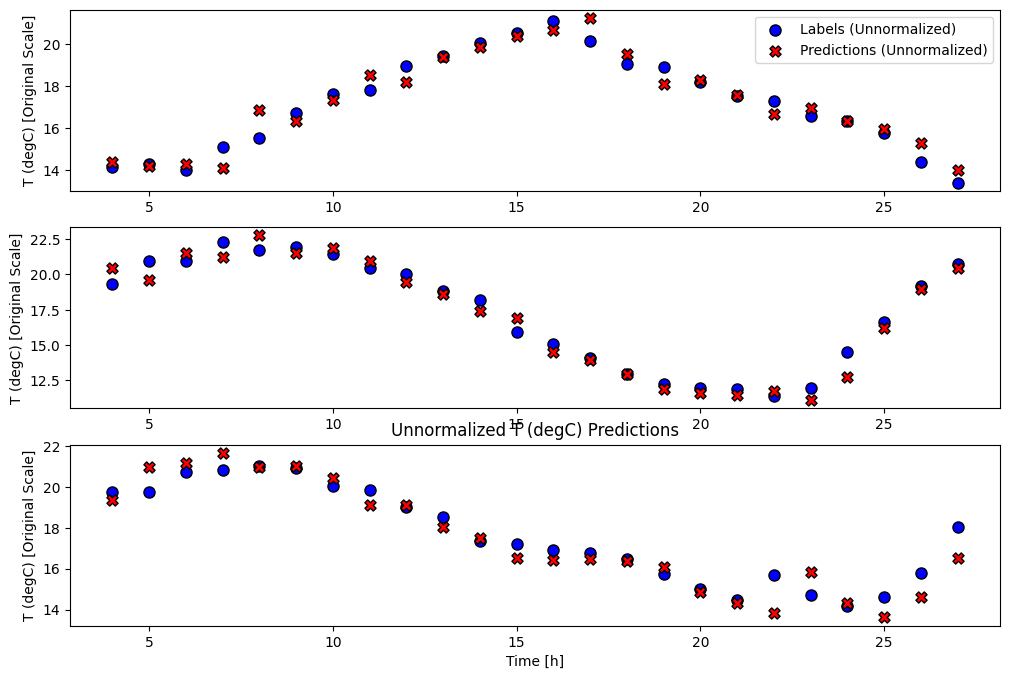

In [68]:
demo_window.plot(conv_model_temp)

### Pressure

#### Test Set, 3 Samples

In [69]:
CONV_WIDTH = 4
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
train_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['p (mbar)'])

In [70]:
conv_model_pressure = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [71]:
history = compile_and_fit(conv_model_pressure, train_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model_pressure.evaluate(train_window.val, return_dict=True)
performance['Conv'] = conv_model_pressure.evaluate(train_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 0.0016 - mean_absolute_error: 0.0282


In [72]:
demo_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['p (mbar)']
)

demo_window.set_example_type("test") # Set example type to validation

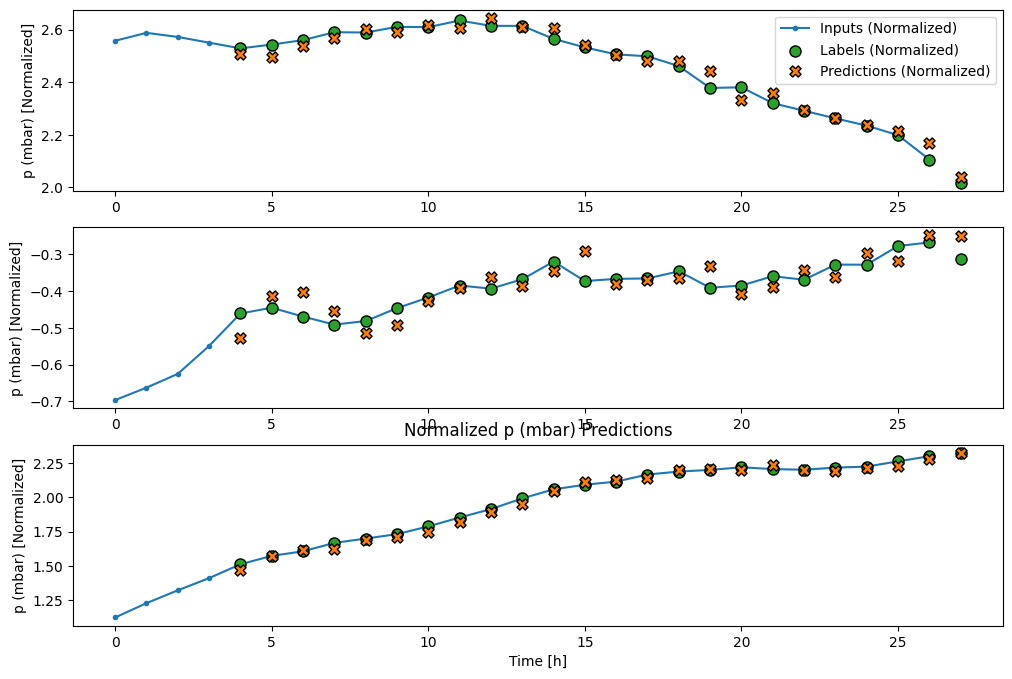

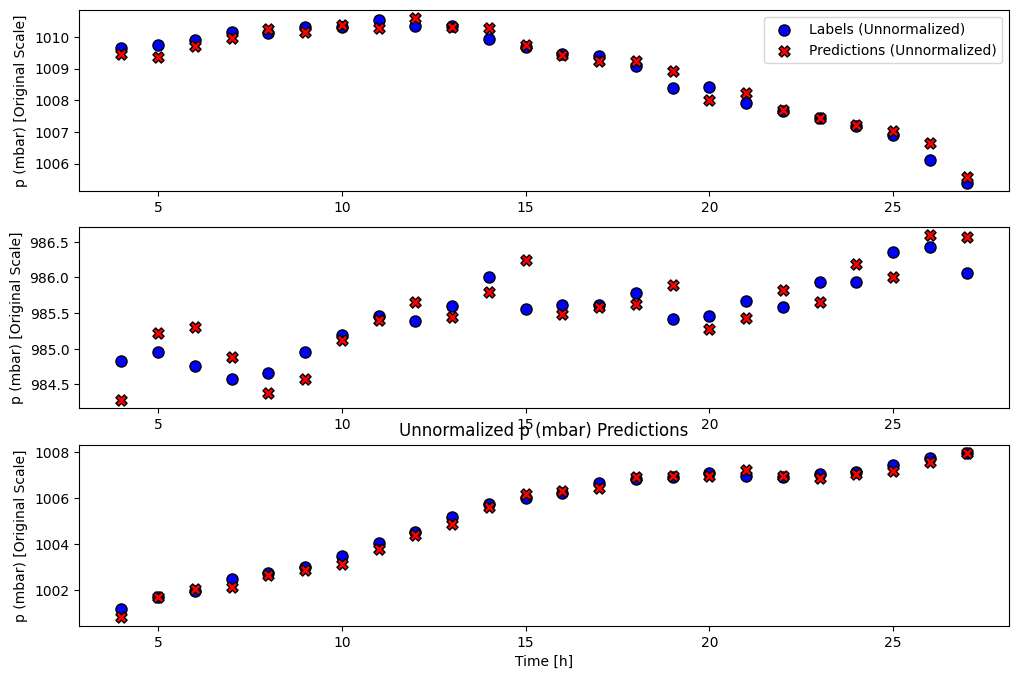

In [73]:
demo_window.plot(conv_model_pressure, plot_col='p (mbar)')

### Relative Humidity

#### Test set, 3 samples

In [74]:
CONV_WIDTH = 4
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
train_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['rh (%)'])

In [75]:
conv_model_rh= tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [76]:
history = compile_and_fit(conv_model_rh, train_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model_rh.evaluate(train_window.val, return_dict=True)
performance['Conv'] = conv_model_rh.evaluate(train_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 0.0502 - mean_absolute_error: 0.1487


In [77]:
demo_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['rh (%)']
)

demo_window.set_example_type("test") # Set example type to validation

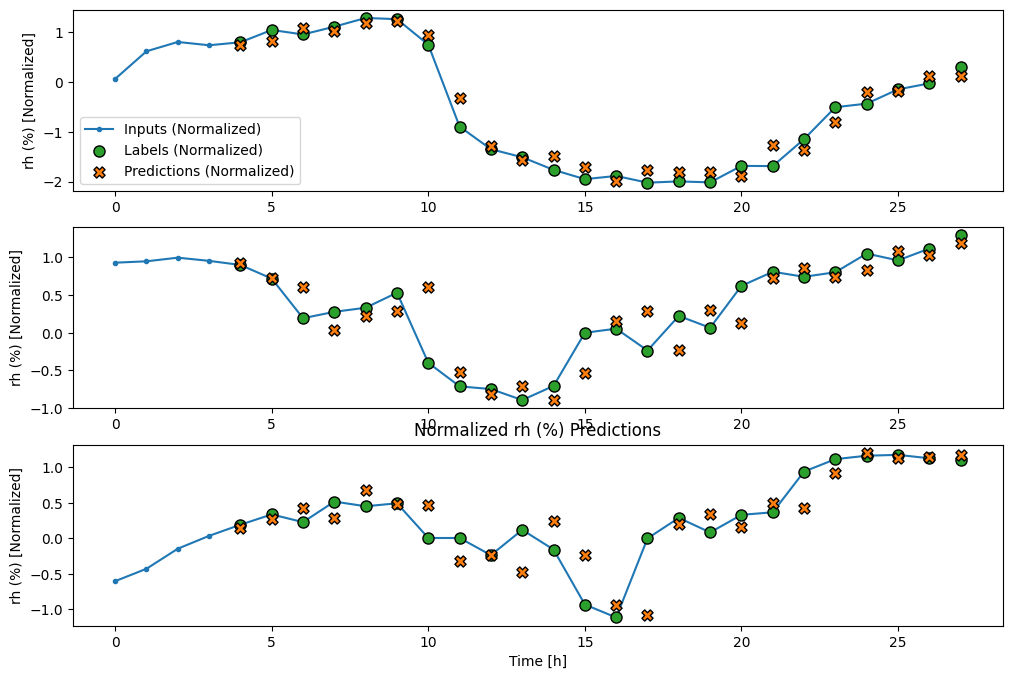

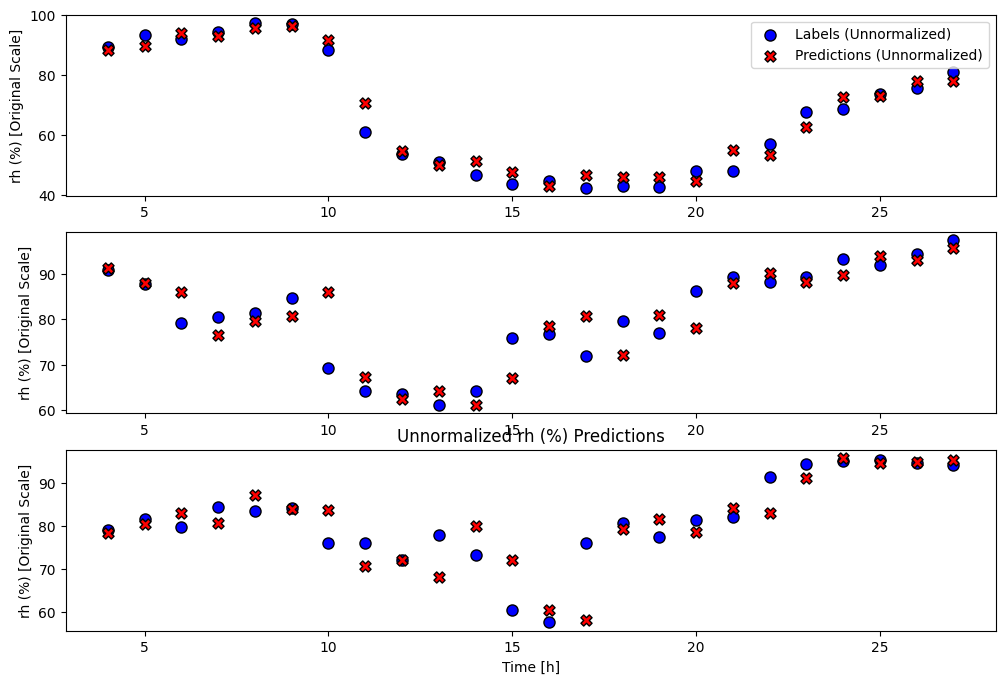

In [78]:
demo_window.plot(conv_model_rh, plot_col='rh (%)')

### Wind Speed

#### Test set, 3 samples

In [79]:
CONV_WIDTH = 4
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
train_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['wv (m/s)'])

In [80]:
conv_model_wv= tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [81]:
history = compile_and_fit(conv_model_wv, train_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model_wv.evaluate(train_window.val, return_dict=True)
performance['Conv'] = conv_model_wv.evaluate(train_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 0.3448 - mean_absolute_error: 0.4245


In [82]:
demo_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['wv (m/s)']
)

demo_window.set_example_type("test") # Set example type to validation

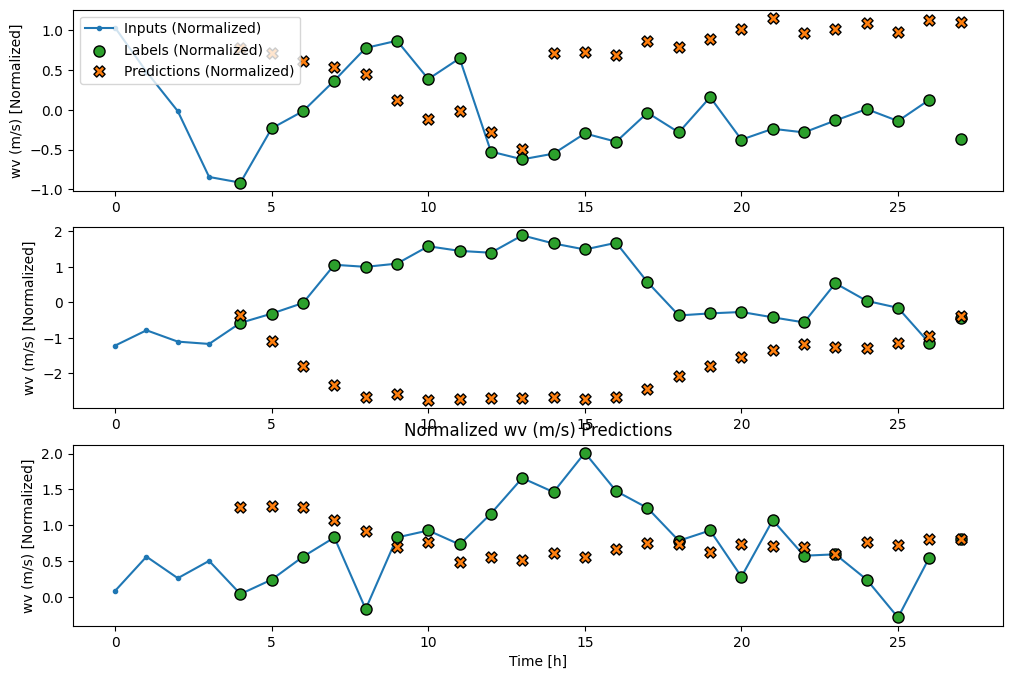

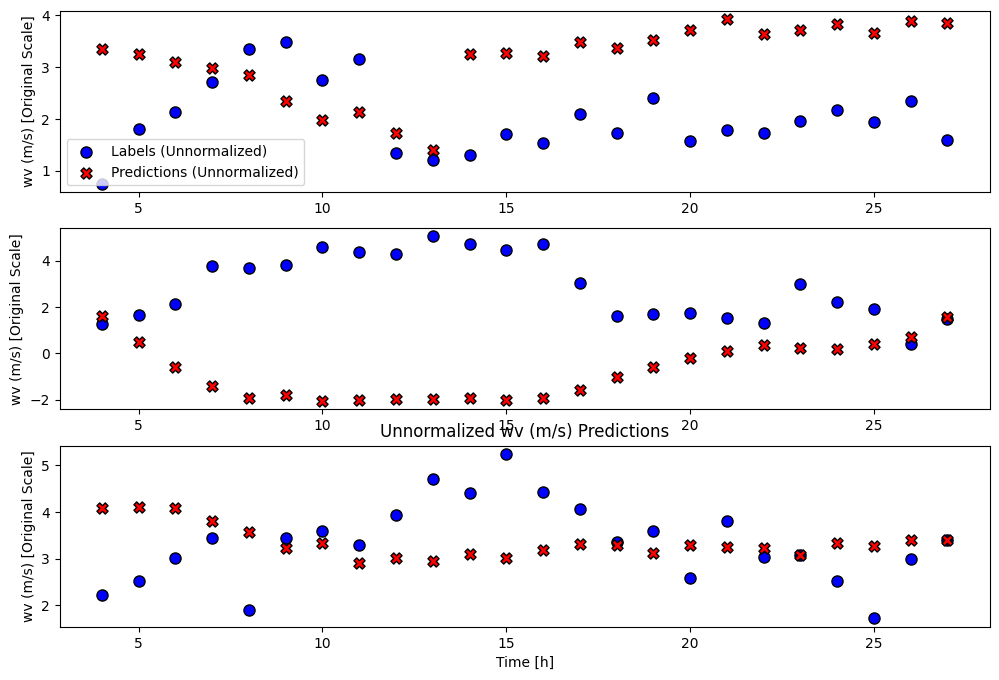

In [83]:
demo_window.plot(conv_model_rh, plot_col='wv (m/s)')

In [84]:
batch_example_features = demo_window.example[0]
batch_example_labels = demo_window.example[1]

print(batch_example_features.shape)
print(batch_example_labels.shape)

(32, 27, 4)
(32, 24, 1)


In [85]:
first_example_features = batch_example_features[0]
first_example_labels = batch_example_labels[0]

print(first_example_features.shape)
print(first_example_labels.shape)

(27, 4)
(24, 1)


In [86]:
prediction = conv_model_wv.predict(first_example_features[tf.newaxis])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [87]:
prediction

array([[[-0.6235537 ],
        [-0.67809904],
        [-0.26555526],
        [-0.12782414],
        [ 0.19685416],
        [ 0.6024715 ],
        [ 0.7300456 ],
        [ 0.5263124 ],
        [ 0.6099936 ],
        [-0.09804426],
        [-0.6501058 ],
        [-0.45669484],
        [-0.41323796],
        [-0.3870949 ],
        [-0.16347617],
        [-0.3008872 ],
        [-0.04721655],
        [-0.37781316],
        [-0.27077708],
        [-0.29768065],
        [-0.26442227],
        [-0.13951617],
        [-0.21244471],
        [-0.03948267]]], dtype=float32)

In [88]:
first_example_labels_unnorm = (first_example_labels * train_std['wv (m/s)']) + train_mean['wv (m/s)']

first_example_labels_unnorm

<tf.Tensor: shape=(24, 1), dtype=float32, numpy=
array([[0.7499999],
       [1.8      ],
       [2.1299999],
       [2.7199998],
       [3.35     ],
       [3.4899998],
       [2.75     ],
       [3.1499999],
       [1.3499999],
       [1.1999998],
       [1.31     ],
       [1.6999998],
       [1.5399998],
       [2.1      ],
       [1.7199999],
       [2.3999999],
       [1.5799999],
       [1.7899998],
       [1.7199999],
       [1.9499999],
       [2.1699998],
       [1.9399998],
       [2.35     ],
       [1.5999999]], dtype=float32)>

In [89]:
prediction_unnorm = (prediction * train_std['wv (m/s)']) + train_mean['wv (m/s)']

prediction_unnorm

array([[[1.19730141],
        [1.11358816],
        [1.74673807],
        [1.95812035],
        [2.45641908],
        [3.07893862],
        [3.27473253],
        [2.96205381],
        [3.09048314],
        [2.00382491],
        [1.15655071],
        [1.45338736],
        [1.52008264],
        [1.56020562],
        [1.90340355],
        [1.69251252],
        [2.08183253],
        [1.57445071],
        [1.73872391],
        [1.69743376],
        [1.74847693],
        [1.94017605],
        [1.82824928],
        [2.09370207]]])

## Multi-headed CNN

In [90]:
# Single head

"""
conv_model_rh= tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
"""

"\nconv_model_rh= tf.keras.Sequential([\n    tf.keras.layers.Conv1D(filters=32,\n                           kernel_size=(CONV_WIDTH,),\n                           activation='relu'),\n    tf.keras.layers.Dense(units=32, activation='relu'),\n    tf.keras.layers.Dense(units=1),\n"

In [91]:
# Your parameters
CONV_WIDTH = 4
OUT_STEPS = 24
NUM_FEATURES = 4  # p, T, rh, wv

train_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    label_columns=['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)'])

In [92]:
import tensorflow as tf

# Define multi-output CNN model
multi_output_cnn = tf.keras.Sequential([
    # 🔹 Shared Convolutional Backbone
    tf.keras.layers.Conv1D(filters=32, kernel_size=CONV_WIDTH, activation='relu'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=CONV_WIDTH, activation='relu'),

    # 🔹 Shared representation
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),

    # 🔹 Multi-Output Dense Layer
    tf.keras.layers.Dense(units=OUT_STEPS * NUM_FEATURES),  # Predicts all variables at once

    # 🔹 Reshape to (time_steps, num_features) to match multi-output format
    tf.keras.layers.Reshape((OUT_STEPS, NUM_FEATURES))  # (batch_size, 24, 4)
])

In [93]:
train_window.example[1].shape

TensorShape([32, 24, 4])

In [94]:
train_window.train

<_MapDataset element_spec=(TensorSpec(shape=(None, 27, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 4), dtype=tf.float32, name=None))>

In [95]:
history = compile_and_fit(
    multi_output_cnn, 
    train_window,
    learning_rate=5e-4,
    patience=10
)

IPython.display.clear_output()
val_performance['Conv'] = multi_output_cnn.evaluate(train_window.val, return_dict=True)
performance['Conv'] = multi_output_cnn.evaluate(train_window.test, verbose=0, return_dict=True)

437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 0.3673 - mean_absolute_error: 0.4112


In [96]:
demo_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']
)

demo_window.set_example_type("test") # Set example type to validation

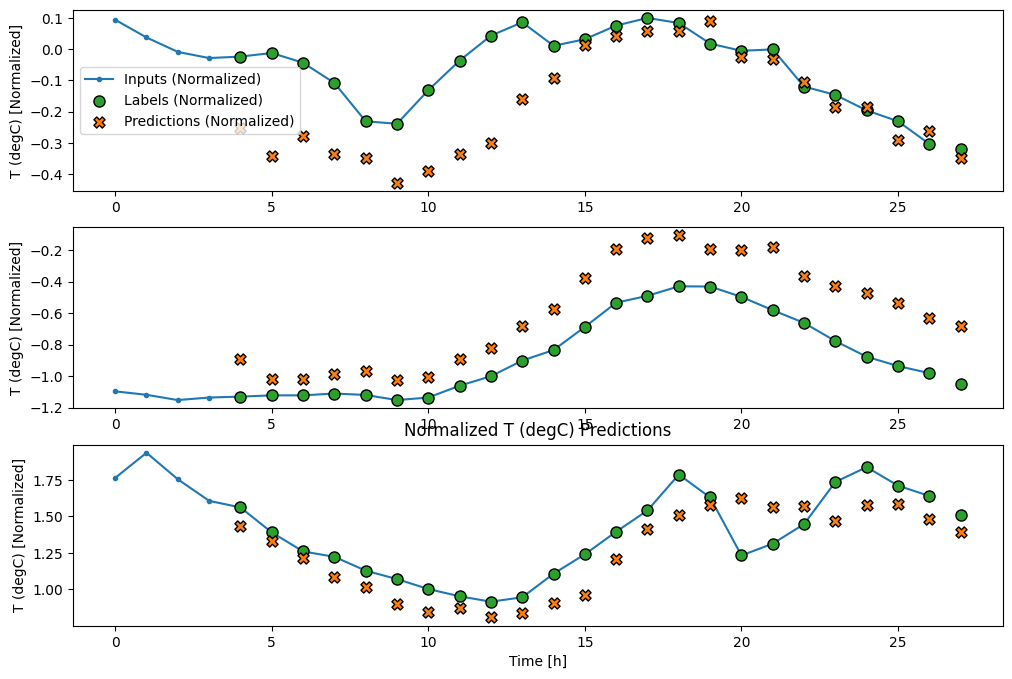

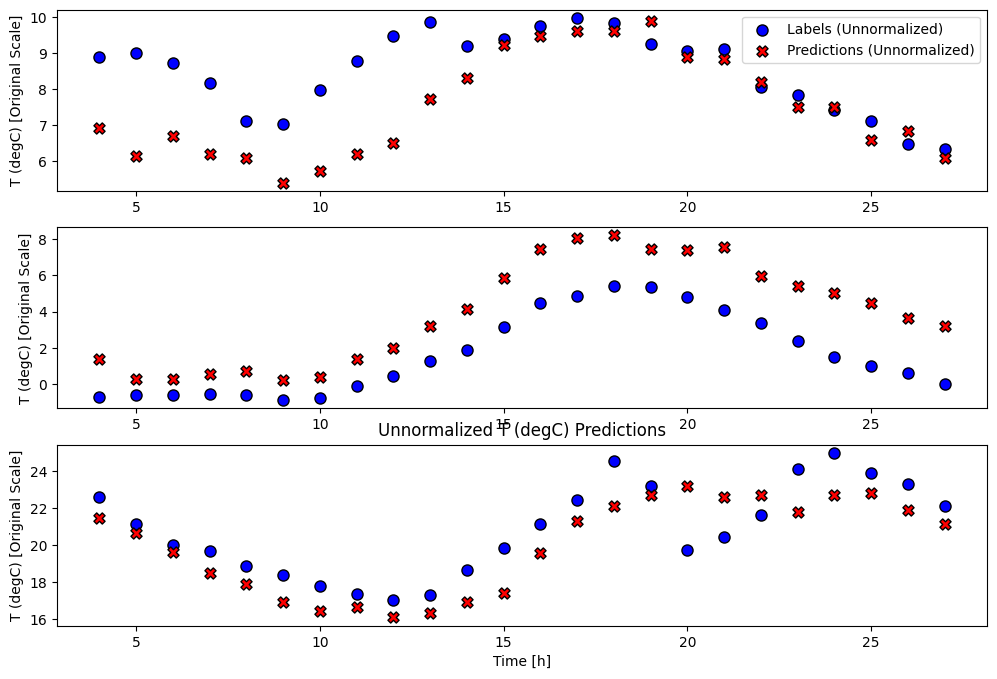

In [97]:
demo_window.plot(multi_output_cnn, plot_col='T (degC)')

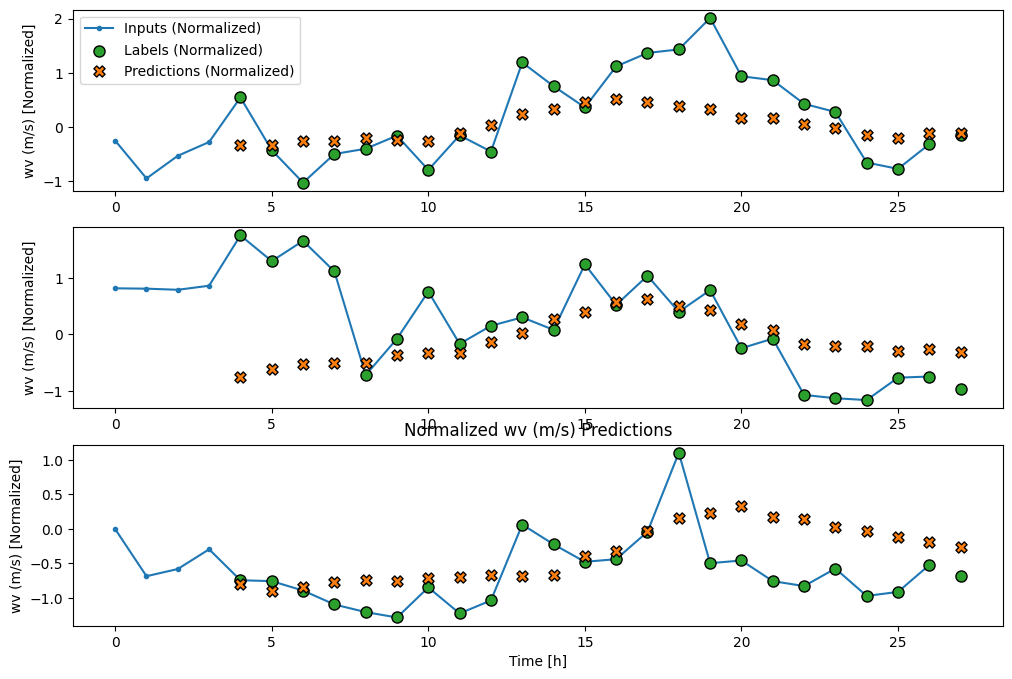

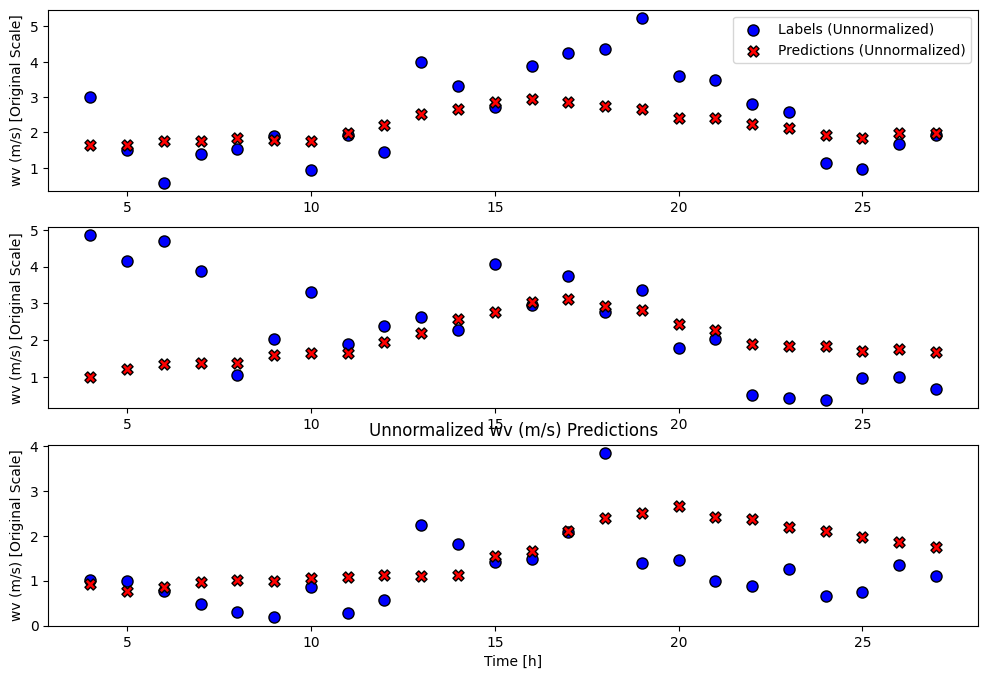

In [98]:
demo_window.plot(multi_output_cnn, plot_col='wv (m/s)')

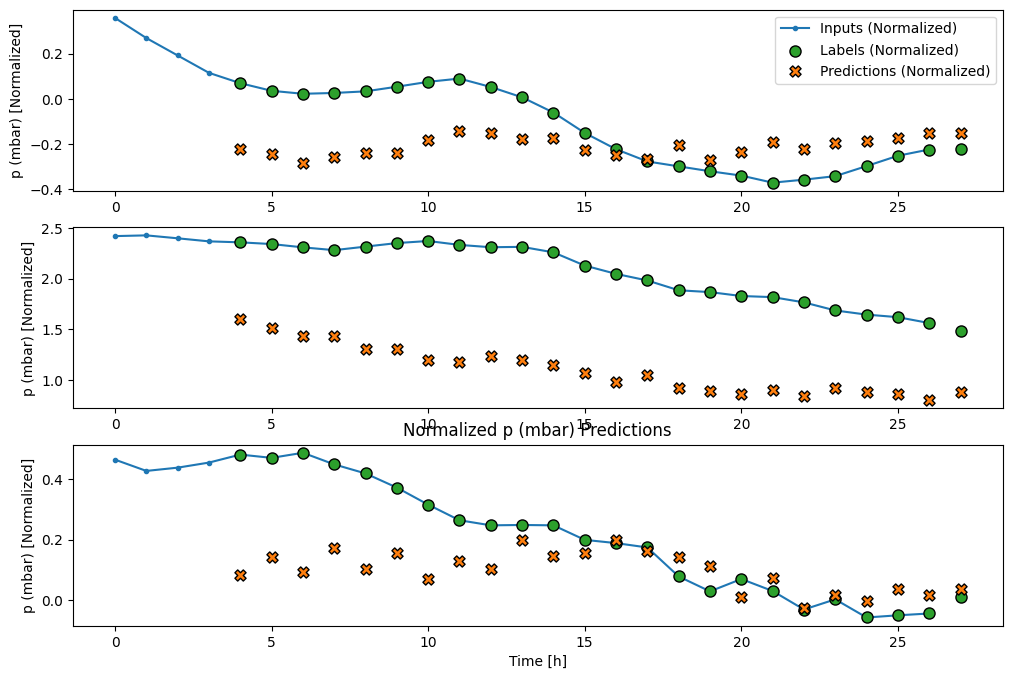

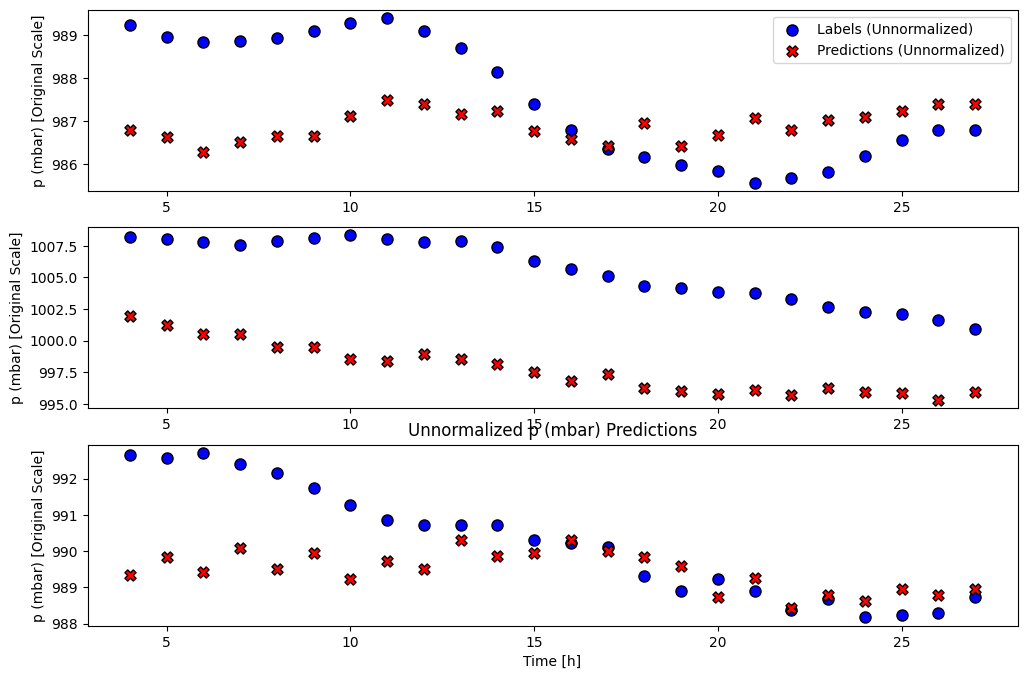

In [99]:
demo_window.plot(multi_output_cnn, plot_col='p (mbar)')

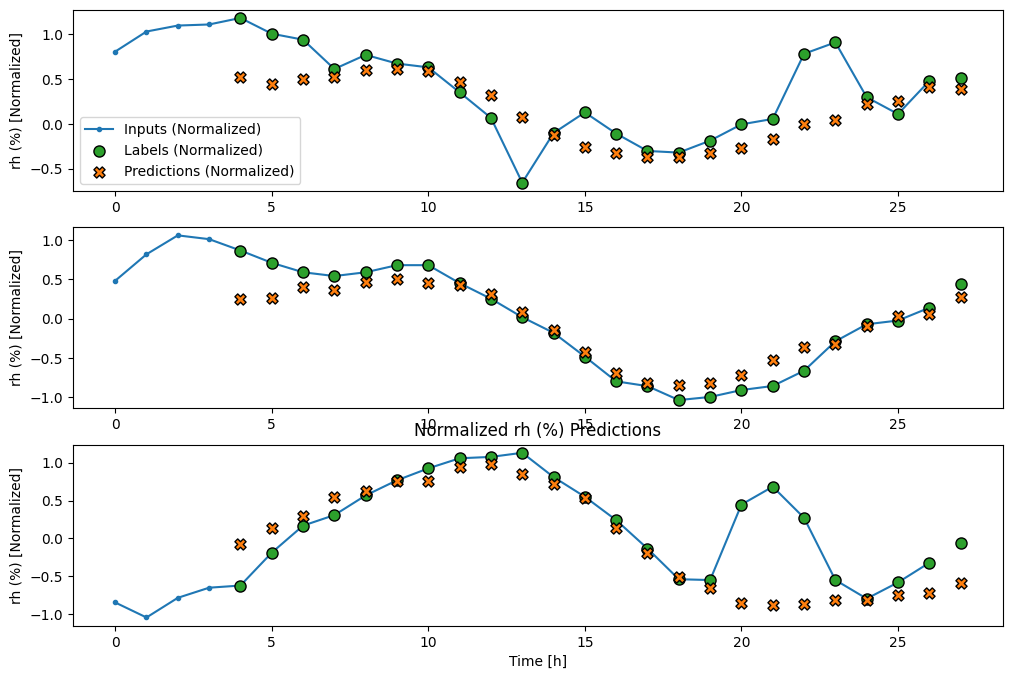

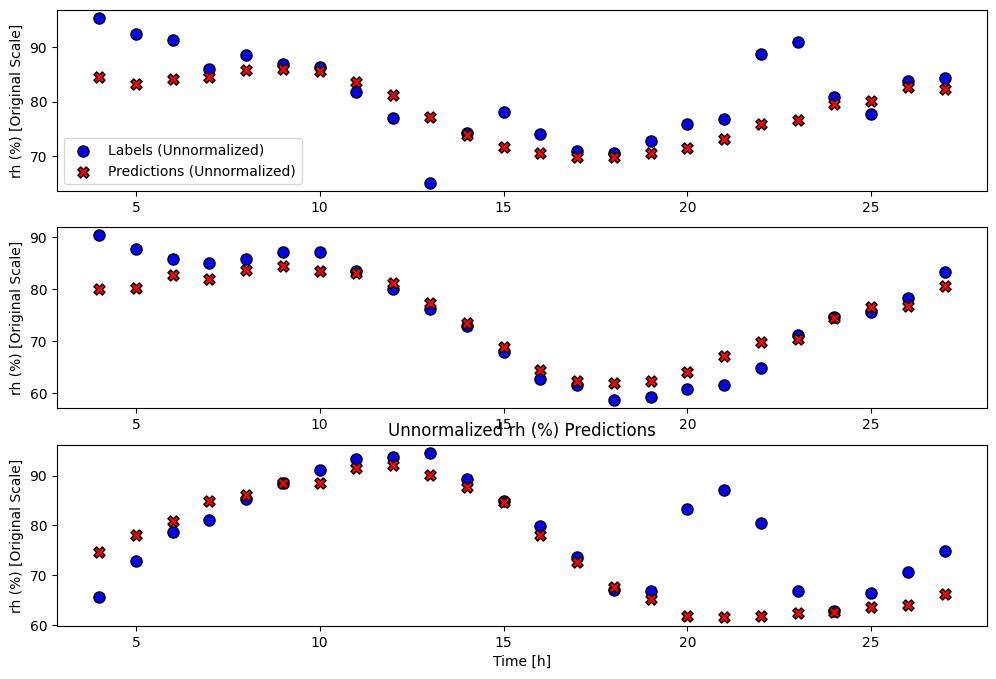

In [100]:
demo_window.plot(multi_output_cnn, plot_col='rh (%)')

In [101]:
demo_window.example[0][0].shape

TensorShape([27, 4])

In [102]:
demo_window.example

(<tf.Tensor: shape=(32, 27, 4), dtype=float32, numpy=
 array([[[ 0.3583814 ,  0.09379528,  0.80300343, -0.2503984 ],
         [ 0.26919755,  0.03718027,  1.0264963 , -0.9475822 ],
         [ 0.19206555, -0.00903605,  1.0929401 , -0.53057504],
         ...,
         [-0.29844567, -0.19621217,  0.29561415, -0.65437406],
         [-0.25264856, -0.23087442,  0.10836335, -0.7716573 ],
         [-0.22492924, -0.30366513,  0.47682458, -0.31555575]],
 
        [[ 2.4180465 , -1.0962752 ,  0.48286495,  0.81818235],
         [ 2.4252775 , -1.118228  ,  0.82112443,  0.8116666 ],
         [ 2.396353  , -1.1517347 ,  1.0627384 ,  0.7921194 ],
         ...,
         [ 1.6443162 , -0.8767476 , -0.07284711, -1.1626015 ],
         [ 1.6190072 , -0.9356734 , -0.02452432, -0.76514155],
         [ 1.5611583 , -0.98073435,  0.13856508, -0.7455943 ]],
 
        [[ 0.46564308,  1.7633601 , -0.84359556, -0.00280043],
         [ 0.42828226,  1.9355159 , -1.041719  , -0.6869527 ],
         [ 0.43912894,  1.7541

In [103]:
multi_output_cnn.predict(demo_window.example[0][0][tf.newaxis])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


array([[[-0.2235359 , -0.25302428,  0.51624274, -0.34007487],
        [-0.24451149, -0.34272867,  0.44646424, -0.333277  ],
        [-0.28548336, -0.27731398,  0.5016932 , -0.25905535],
        [-0.25919428, -0.33502904,  0.5164044 , -0.26199725],
        [-0.24004161, -0.34888196,  0.5999577 , -0.2052933 ],
        [-0.23988509, -0.42731786,  0.6150506 , -0.24641255],
        [-0.18393081, -0.3885958 ,  0.5856743 , -0.24883775],
        [-0.1415505 , -0.33703116,  0.4654652 , -0.1022691 ],
        [-0.15169594, -0.30007058,  0.3159013 ,  0.04390271],
        [-0.18046302, -0.16036564,  0.07106309,  0.241386  ],
        [-0.17218654, -0.09250502, -0.12510383,  0.34055156],
        [-0.22618642,  0.01382025, -0.25856733,  0.4584554 ],
        [-0.24849977,  0.04169717, -0.32408842,  0.51907206],
        [-0.26923022,  0.05731967, -0.37369502,  0.4633646 ],
        [-0.2038346 ,  0.05727622, -0.37080616,  0.38033125],
        [-0.270373  ,  0.08920173, -0.3206981 ,  0.32573754],
        

This is the format it needs.

In [104]:
demo_window.example[0][0][tf.newaxis].shape

TensorShape([1, 27, 4])

In [105]:
import numpy as np
import tensorflow as tf
from typing import List, Dict

class WindowGeneratorPredict():
    def __init__(self, input_width: int):
        """
        Class to handle real-time inference for sensor readings.

        Parameters:
        - input_width: Number of past time steps to use for prediction.
        """
        self.input_width = input_width  # How many past time steps to use
        self.feature_columns = ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']

    def preprocess(self, sensor_readings: List[Dict]) -> tf.Tensor:
        """
        Convert raw sensor readings (list of dicts) into a properly normalized input tensor.
        """
        if len(sensor_readings) < self.input_width:
            raise ValueError(f"Expected at least {self.input_width} time steps, but got {len(sensor_readings)}.")
        
        # 🚀 Convert sensor readings into a NumPy array
        data = np.array([[entry[col] for col in self.feature_columns] for entry in sensor_readings[-self.input_width:]], dtype=np.float32)

        # 🚀 Normalize using training mean & std
        data = (data - train_mean[self.feature_columns].values) / train_std[self.feature_columns].values

        # 🚀 Reshape for model input (batch_size=1, time_steps=input_width, num_features)
        return tf.convert_to_tensor(data.reshape(1, self.input_width, len(self.feature_columns)), dtype=tf.float32)

    def predict(self, model, sensor_readings) -> Dict:
        """
        Run inference using the given trained model.
        
        Parameters:
        - model: The trained multi-output model.
        - sensor_readings: List of dictionaries with latest sensor data.

        Returns:
        - Dictionary with predictions for each feature over the next 24 timesteps.
        """
        input_tensor = self.preprocess(sensor_readings)
        predictions = model.predict(input_tensor)

        print("Raw Predictions (Normalized):")
        print(predictions[0][:5])

        predictions = np.array(predictions)

        result = []
        
        for i in range(predictions.shape[1]):  # Loop through 24 time steps
            hour_prediction = predictions[0, i, :]  # Extract one time step
            
            pressure_unnormalised = (hour_prediction[0] * train_std['p (mbar)']) + train_mean['p (mbar)']
            temperature_unnormalised = (hour_prediction[1] * train_std['T (degC)']) + train_mean['T (degC)']
            relative_humidity_unnormalised = (hour_prediction[2] * train_std['rh (%)']) + train_mean['rh (%)']
            wind_speed_unnormalised = (hour_prediction[3] * train_std['wv (m/s)']) + train_mean['wv (m/s)']

            result.append({
                "Hour": i + 1,
                "p (mbar)": round(float(pressure_unnormalised), 2),
                "T (degC)": round(float(temperature_unnormalised), 2),
                "rh (%)": round(float(relative_humidity_unnormalised), 2),
                "wv (m/s)": round(float(wind_speed_unnormalised), 2),
            })

        return result

In [106]:
fake_data = [
  {"timestamp": "2025-03-17 07:17:42", "T (degC)": 19.6, "wv (m/s)": 2.88, "p (mbar)": 1011.42, "rh (%)": 58.79},
  {"timestamp": "2025-03-17 08:17:42", "T (degC)": 19.62, "wv (m/s)": 2.8, "p (mbar)": 1012.41, "rh (%)": 61.62},
  {"timestamp": "2025-03-17 09:17:42", "T (degC)": 19.96, "wv (m/s)": 3.19, "p (mbar)": 1011.52, "rh (%)": 60.68},
  {"timestamp": "2025-03-17 10:17:42", "T (degC)": 20.11, "wv (m/s)": 2.95, "p (mbar)": 1011.44, "rh (%)": 61.12},
  {"timestamp": "2025-03-17 11:17:42", "T (degC)": 19.6, "wv (m/s)": 3.1, "p (mbar)": 1012.46, "rh (%)": 59.75},
  {"timestamp": "2025-03-17 12:17:42", "T (degC)": 20.08, "wv (m/s)": 2.93, "p (mbar)": 1012.39, "rh (%)": 58.61},
  {"timestamp": "2025-03-17 13:17:42", "T (degC)": 19.59, "wv (m/s)": 2.82, "p (mbar)": 1012.09, "rh (%)": 58.81},
  {"timestamp": "2025-03-17 14:17:42", "T (degC)": 19.56, "wv (m/s)": 3.02, "p (mbar)": 1012.55, "rh (%)": 61.36},
  {"timestamp": "2025-03-17 15:17:42", "T (degC)": 19.93, "wv (m/s)": 3.04, "p (mbar)": 1011.54, "rh (%)": 58.72},
  {"timestamp": "2025-03-17 16:17:42", "T (degC)": 19.84, "wv (m/s)": 3.07, "p (mbar)": 1011.0, "rh (%)": 60.11},
  {"timestamp": "2025-03-17 17:17:42", "T (degC)": 19.67, "wv (m/s)": 2.96, "p (mbar)": 1011.61, "rh (%)": 60.91},
  {"timestamp": "2025-03-17 18:17:42", "T (degC)": 19.86, "wv (m/s)": 2.82, "p (mbar)": 1012.88, "rh (%)": 58.55},
  {"timestamp": "2025-03-17 19:17:42", "T (degC)": 19.97, "wv (m/s)": 2.91, "p (mbar)": 1012.54, "rh (%)": 61.85},
  {"timestamp": "2025-03-17 20:17:42", "T (degC)": 19.99, "wv (m/s)": 3.19, "p (mbar)": 1012.88, "rh (%)": 61.91},
  {"timestamp": "2025-03-17 21:17:42", "T (degC)": 19.63, "wv (m/s)": 3.07, "p (mbar)": 1011.28, "rh (%)": 59.88},
  {"timestamp": "2025-03-17 22:17:42", "T (degC)": 20.22, "wv (m/s)": 2.91, "p (mbar)": 1012.48, "rh (%)": 59.52},
  {"timestamp": "2025-03-17 23:17:42", "T (degC)": 19.7, "wv (m/s)": 3.03, "p (mbar)": 1011.62, "rh (%)": 59.09},
  {"timestamp": "2025-03-18 00:17:42", "T (degC)": 20.31, "wv (m/s)": 2.99, "p (mbar)": 1011.32, "rh (%)": 61.03},
  {"timestamp": "2025-03-18 01:17:42", "T (degC)": 19.83, "wv (m/s)": 2.88, "p (mbar)": 1011.82, "rh (%)": 60.14},
  {"timestamp": "2025-03-18 02:17:42", "T (degC)": 19.75, "wv (m/s)": 2.93, "p (mbar)": 1011.95, "rh (%)": 58.42},
  {"timestamp": "2025-03-18 03:17:42", "T (degC)": 20.3, "wv (m/s)": 2.94, "p (mbar)": 1012.67, "rh (%)": 59.65},
  {"timestamp": "2025-03-18 04:17:42", "T (degC)": 20.35, "wv (m/s)": 3.13, "p (mbar)": 1011.71, "rh (%)": 59.74},
  {"timestamp": "2025-03-18 05:17:42", "T (degC)": 19.52, "wv (m/s)": 3.18, "p (mbar)": 1011.31, "rh (%)": 61.76},
  {"timestamp": "2025-03-18 06:17:42", "T (degC)": 20.42, "wv (m/s)": 2.83, "p (mbar)": 1011.45, "rh (%)": 60.94},
  {"timestamp": "2025-03-18 07:17:42", "T (degC)": 20.03, "wv (m/s)": 2.82, "p (mbar)": 1012.44, "rh (%)": 61.71},
  {"timestamp": "2025-03-18 08:17:42", "T (degC)": 19.93, "wv (m/s)": 3.19, "p (mbar)": 1011.6, "rh (%)": 58.06},
  {"timestamp": "2025-03-18 09:17:42", "T (degC)": 19.8, "wv (m/s)": 2.85, "p (mbar)": 1012.3, "rh (%)": 61.84}
]

In [107]:
sensor_window = WindowGeneratorPredict(
    input_width=INPUT_WIDTH,
)

In [108]:
sensor_window.predict(multi_output_cnn, fake_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Raw Predictions (Normalized):
[[ 2.532423    1.143228   -0.6802151   0.12119875]
 [ 2.4668987   1.1314051  -0.794055    0.04919716]
 [ 2.5885684   1.1142881  -0.72136855  0.11023756]
 [ 2.6907191   1.157503   -0.69900554  0.12138409]
 [ 2.5129335   1.0238842  -0.8112554  -0.0730559 ]]


[{'Hour': 1,
  'p (mbar)': 1009.67,
  'T (degC)': 19.0,
  'rh (%)': 64.64,
  'wv (m/s)': 2.34},
 {'Hour': 2,
  'p (mbar)': 1009.13,
  'T (degC)': 18.9,
  'rh (%)': 62.76,
  'wv (m/s)': 2.23},
 {'Hour': 3,
  'p (mbar)': 1010.13,
  'T (degC)': 18.75,
  'rh (%)': 63.96,
  'wv (m/s)': 2.32},
 {'Hour': 4,
  'p (mbar)': 1010.98,
  'T (degC)': 19.13,
  'rh (%)': 64.33,
  'wv (m/s)': 2.34},
 {'Hour': 5,
  'p (mbar)': 1009.51,
  'T (degC)': 17.97,
  'rh (%)': 62.48,
  'wv (m/s)': 2.04},
 {'Hour': 6,
  'p (mbar)': 1010.13,
  'T (degC)': 18.39,
  'rh (%)': 62.16,
  'wv (m/s)': 2.27},
 {'Hour': 7,
  'p (mbar)': 1010.09,
  'T (degC)': 17.88,
  'rh (%)': 65.34,
  'wv (m/s)': 2.36},
 {'Hour': 8,
  'p (mbar)': 1010.22,
  'T (degC)': 18.1,
  'rh (%)': 63.9,
  'wv (m/s)': 2.07},
 {'Hour': 9,
  'p (mbar)': 1010.04,
  'T (degC)': 17.31,
  'rh (%)': 68.14,
  'wv (m/s)': 2.43},
 {'Hour': 10,
  'p (mbar)': 1009.58,
  'T (degC)': 17.95,
  'rh (%)': 62.62,
  'wv (m/s)': 2.18},
 {'Hour': 11,
  'p (mbar)': 1008.

Our model works! Just need to follow this format:

```
fake_data = [
  {"timestamp": "2025-03-17 07:17:42", "T (degC)": 19.6, "wv (m/s)": 2.88, "p (mbar)": 1011.42, "rh (%)": 58.79},
  {"timestamp": "2025-03-17 08:17:42", "T (degC)": 19.62, "wv (m/s)": 2.8, "p (mbar)": 1012.41, "rh (%)": 61.62},
  {"timestamp": "2025-03-17 09:17:42", "T (degC)": 19.96, "wv (m/s)": 3.19, "p (mbar)": 1011.52, "rh (%)": 60.68},
  {"timestamp": "2025-03-17 10:17:42", "T (degC)": 20.11, "wv (m/s)": 2.95, "p (mbar)": 1011.44, "rh (%)": 61.12},
  {"timestamp": "2025-03-17 11:17:42", "T (degC)": 19.6, "wv (m/s)": 3.1, "p (mbar)": 1012.46, "rh (%)": 59.75},
  {"timestamp": "2025-03-17 12:17:42", "T (degC)": 20.08, "wv (m/s)": 2.93, "p (mbar)": 1012.39, "rh (%)": 58.61},
  {"timestamp": "2025-03-17 13:17:42", "T (degC)": 19.59, "wv (m/s)": 2.82, "p (mbar)": 1012.09, "rh (%)": 58.81},
  {"timestamp": "2025-03-17 14:17:42", "T (degC)": 19.56, "wv (m/s)": 3.02, "p (mbar)": 1012.55, "rh (%)": 61.36},
  {"timestamp": "2025-03-17 15:17:42", "T (degC)": 19.93, "wv (m/s)": 3.04, "p (mbar)": 1011.54, "rh (%)": 58.72},
  {"timestamp": "2025-03-17 16:17:42", "T (degC)": 19.84, "wv (m/s)": 3.07, "p (mbar)": 1011.0, "rh (%)": 60.11},
  {"timestamp": "2025-03-17 17:17:42", "T (degC)": 19.67, "wv (m/s)": 2.96, "p (mbar)": 1011.61, "rh (%)": 60.91},
  {"timestamp": "2025-03-17 18:17:42", "T (degC)": 19.86, "wv (m/s)": 2.82, "p (mbar)": 1012.88, "rh (%)": 58.55},
  {"timestamp": "2025-03-17 19:17:42", "T (degC)": 19.97, "wv (m/s)": 2.91, "p (mbar)": 1012.54, "rh (%)": 61.85},
  {"timestamp": "2025-03-17 20:17:42", "T (degC)": 19.99, "wv (m/s)": 3.19, "p (mbar)": 1012.88, "rh (%)": 61.91},
  {"timestamp": "2025-03-17 21:17:42", "T (degC)": 19.63, "wv (m/s)": 3.07, "p (mbar)": 1011.28, "rh (%)": 59.88},
  {"timestamp": "2025-03-17 22:17:42", "T (degC)": 20.22, "wv (m/s)": 2.91, "p (mbar)": 1012.48, "rh (%)": 59.52},
  {"timestamp": "2025-03-17 23:17:42", "T (degC)": 19.7, "wv (m/s)": 3.03, "p (mbar)": 1011.62, "rh (%)": 59.09},
  {"timestamp": "2025-03-18 00:17:42", "T (degC)": 20.31, "wv (m/s)": 2.99, "p (mbar)": 1011.32, "rh (%)": 61.03},
  {"timestamp": "2025-03-18 01:17:42", "T (degC)": 19.83, "wv (m/s)": 2.88, "p (mbar)": 1011.82, "rh (%)": 60.14},
  {"timestamp": "2025-03-18 02:17:42", "T (degC)": 19.75, "wv (m/s)": 2.93, "p (mbar)": 1011.95, "rh (%)": 58.42},
  {"timestamp": "2025-03-18 03:17:42", "T (degC)": 20.3, "wv (m/s)": 2.94, "p (mbar)": 1012.67, "rh (%)": 59.65},
  {"timestamp": "2025-03-18 04:17:42", "T (degC)": 20.35, "wv (m/s)": 3.13, "p (mbar)": 1011.71, "rh (%)": 59.74},
  {"timestamp": "2025-03-18 05:17:42", "T (degC)": 19.52, "wv (m/s)": 3.18, "p (mbar)": 1011.31, "rh (%)": 61.76},
  {"timestamp": "2025-03-18 06:17:42", "T (degC)": 20.42, "wv (m/s)": 2.83, "p (mbar)": 1011.45, "rh (%)": 60.94},
  {"timestamp": "2025-03-18 07:17:42", "T (degC)": 20.03, "wv (m/s)": 2.82, "p (mbar)": 1012.44, "rh (%)": 61.71},
  {"timestamp": "2025-03-18 08:17:42", "T (degC)": 19.93, "wv (m/s)": 3.19, "p (mbar)": 1011.6, "rh (%)": 58.06},
  {"timestamp": "2025-03-18 09:17:42", "T (degC)": 19.8, "wv (m/s)": 2.85, "p (mbar)": 1012.3, "rh (%)": 61.84}
]
```

You need 27 timestamp records, each containing the four sensor data.

## Export the Multi-Output CNN model

In [111]:
multi_output_cnn.save("multi_output_cnn.keras")